In [203]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import multiprocessing
from torchvision.io import read_image
import os
import sys
import wandb
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.metrics import accuracy_score, confusion_matrix

In [204]:
base_dir = "../.."
sys.path.insert(0, base_dir)
from models.AutoEncoders.AutoEncoders import AutoEncoder_MLP
from models.knn.knn import KNN
from models.AutoEncoders.cnn_autoencoder import CNNAutoencoder
from models.AutoEncoders.pca_autoencoder import PCA_AutoEncoder

# 4. AutoEncoder: Comparative Analysis

## 4.2 CNN AutoEncoder

### 4.2.1 Dataset Analysis and Preprocessing

In [205]:
# load fashion mnist dataset
train_data = pd.read_csv(
    os.path.join(
        base_dir, "data", "external", "fashion_mnist", "fashion-mnist_train.csv"
    )
)
test_data = pd.read_csv(
    os.path.join(
        base_dir, "data", "external", "fashion_mnist", "fashion-mnist_test.csv"
    )
)
val_data = train_data[-10000:]
train_data = train_data[:-10000]

# save to processed
train_data.to_csv(
    os.path.join(base_dir, "data", "processed", "fashion_mnist", "train.csv"), index=False
)
val_data.to_csv(os.path.join(base_dir, "data", "processed", "fashion_mnist", "val.csv"), index=False)
test_data.to_csv(
    os.path.join(base_dir, "data", "processed", "fashion_mnist", "test.csv"), index=False
)

Categories as per the dataset:
|Index|Name|
|-|-|
|0| T-shirt/top |
|1| Trouser |
|2| Pullover |
|3| Dress |
|4| Coat |
|5| Sandal |
|6| Shirt |
|7| Sneaker |
|8| Bag |
|9| Ankle boot |

In [206]:
def load_fashion_mnist_data():
    data_dir = os.path.join(base_dir, "data", "processed", "fashion_mnist")
    
    def make_image_from_row(row):
        return torch.tensor(np.array(row)).reshape(1, 28, 28)/255
    
    def read_dataset(dataset_dir):
        images = []
        labels = []
        dataset = pd.read_csv(os.path.join(data_dir, dataset_dir))
        for i, row in dataset.iterrows():
            images.append(make_image_from_row(row.iloc[1:]).float())
            labels.append(torch.tensor(row.iloc[0]).float())
        images = torch.stack(images)
        labels = torch.vstack(labels)
        return images, labels
    
    train_images, train_labels = read_dataset("train.csv")
    val_images, val_labels = read_dataset("val.csv")
    test_images, test_labels = read_dataset("test.csv")
    
    return train_images, train_labels, val_images, val_labels, test_images, test_labels

In [207]:
train_images, train_labels, val_images, val_labels, test_images, test_labels = load_fashion_mnist_data()

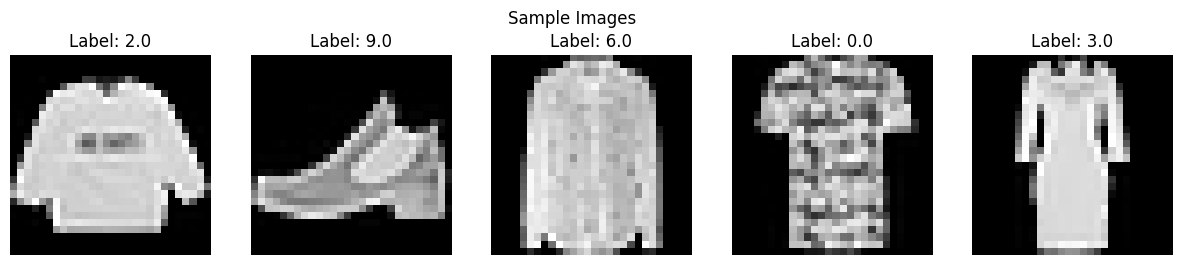

In [174]:
# show some images
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axs):
    ax.imshow(train_images[i][0], cmap="gray")
    ax.set_title(f"Label: {train_labels[i].item()}")
    ax.axis("off") 
plt.suptitle("Sample Images")
plt.show()

In [208]:
# dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = FashionMNISTDataset(train_images, train_labels)
val_dataset = FashionMNISTDataset(val_images, val_labels)
test_dataset = FashionMNISTDataset(test_images, test_labels)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [209]:
# convert a data loader to a matrix
def loader_to_matrix(loader):
    images = []
    for i, (image, _) in enumerate(loader):
        images.append(image.view(image.size(0), -1))
    images = torch.vstack(images)
    return images

### 4.2.2 Sample run of the implemented model

In [180]:
cnn_autoencoder = CNNAutoencoder(epochs=10)
cnn_autoencoder.fit(train_loader, val_loader)

Using device: cuda


Epoch: 1/10, Train Loss: 0.053676145934902345
	Validation Loss: 0.02774359249053108
Epoch: 2/10, Train Loss: 0.02514065257118791
	Validation Loss: 0.023801512292521015
Epoch: 3/10, Train Loss: 0.022481982200823324
	Validation Loss: 0.021333283276125124
Epoch: 4/10, Train Loss: 0.020664994642995965
	Validation Loss: 0.020133739455964913
Epoch: 5/10, Train Loss: 0.01963124183170936
	Validation Loss: 0.01988840289413929
Epoch: 6/10, Train Loss: 0.018957928549545956
	Validation Loss: 0.018580256243515166
Epoch: 7/10, Train Loss: 0.01853271440633804
	Validation Loss: 0.018574606734001714
Epoch: 8/10, Train Loss: 0.01827175349301999
	Validation Loss: 0.018298395375489808
Epoch: 9/10, Train Loss: 0.018073445879151603
	Validation Loss: 0.024186103919129464
Epoch: 10/10, Train Loss: 0.01794610610303214
	Validation Loss: 0.01782679144933725


### 4.2.3 Plots and Visualizations

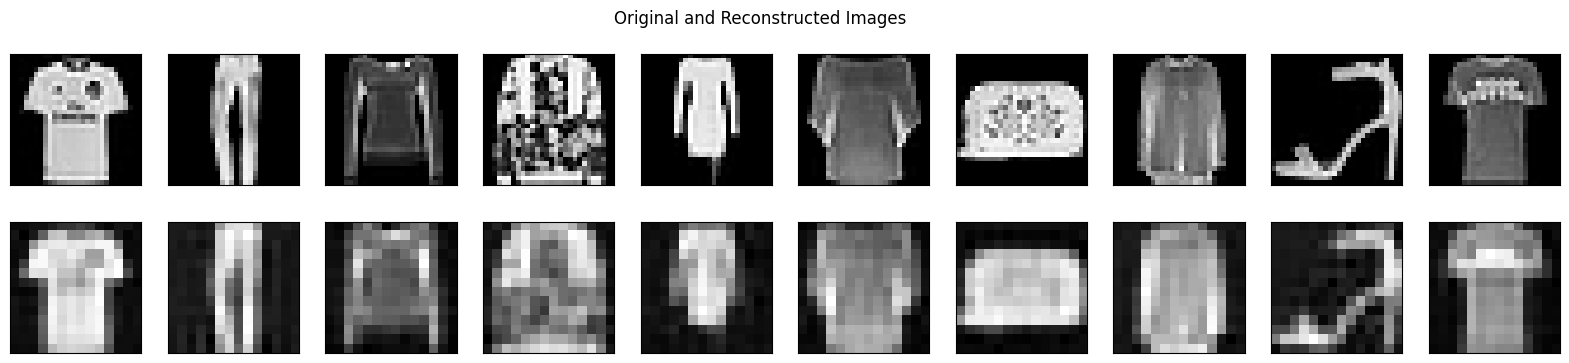

In [181]:
# visualize 10 images(original and reconstructed) from test dataset
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i][0].cpu().numpy(), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cnn_autoencoder.predict(test_images[i].unsqueeze(0)).squeeze().cpu().numpy(), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Original and Reconstructed Images")
plt.show()

In [182]:
# plot of encoded representation in latent space. 
def plot_latent_space(model, data_loader, n_comp):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(model.device)
            latent = model.encode(images).cpu().numpy().reshape(images.shape[0], -1)
            latents.append(latent)
            labels.append(label)
    latents = np.vstack(latents)
    labels = np.vstack(labels)
    pca = PCA(n_components=n_comp)
    latents = pca.fit_transform(latents)
    if n_comp == 2:
        df = pd.DataFrame(latents, columns=["x", "y"])
    if n_comp == 3:
        df = pd.DataFrame(latents, columns=["x", "y", "z"])
    df["label"] = labels
    if n_comp == 2:
        fig = px.scatter(df, x="x", y="y", color="label", title="Latent Space in 2D")
        fig.update_traces(marker=dict(size=3))
    if n_comp == 3:
        fig = px.scatter_3d(df, x="x", y="y", z="z", color="label", title="Latent Space in 3D")
        fig.update_traces(marker=dict(size=2))
    fig.show()
    
plot_latent_space(cnn_autoencoder, test_loader, 2)
plot_latent_space(cnn_autoencoder, test_loader, 3)

### 4.2.4 Hyperparameter Tuning

In [200]:
# hyperparameter sweep for regression task using CNN
sweep_config = {
    "method": "grid",
    "metric": {"name": "loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"values": [0.01, 0.001]},
        "kernel_sizes": {"values": [[3], [5], [3, 3], [3, 3, 3], [3, 5], [3, 5, 7]]},
        "activation_function": {"values": ["relu", "sigmoid", "tanh"]},
        "optimizer": {"values": ["adam", "sgd"]},
        "epochs": {"values": [10, 20]},
    },
}

# sweep
activations = {'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh()}
optimizers = {'adam': optim.Adam, 'sgd': optim.SGD}
run_id = 0

def train():
    global run_id
    wandb.init(project="cnn-autoencoder", name=f"run-{run_id}")
    run_id += 1
    config = wandb.config
    model = CNNAutoencoder(
        learning_rate=config.learning_rate,
        kernel_sizes=config.kernel_sizes,
        channel_sizes=[16,32,64,128, 32][:len(config.kernel_sizes)],
        activation_functions=[activations[config.activation_function]]*len(config.kernel_sizes),
        optimizer=optimizers[config.optimizer],
        epochs=config.epochs,
        log_wandb=True
    )
    model.fit(train_loader, val_loader)
    test_loss = model.evaluate(test_loader, "Test", return_output=True, print_output=False)
    wandb.log(
        {
            "loss": test_loss,
        }
    )

    wandb.finish()

sweep_id = wandb.sweep(sweep_config, project="cnn-autoencoder")
wandb.agent(sweep_id, train)

Create sweep with ID: 8xsxio9y
Sweep URL: https://wandb.ai/gauravbehera-iiith/cnn-autoencoder/sweeps/8xsxio9y


wandb: Agent Starting Run: 03crdy1f with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.018458709616185454
	Validation Loss: 0.016060654050225665
Epoch: 2/10, Train Loss: 0.015892186984562736
	Validation Loss: 0.01594387661594494
Epoch: 3/10, Train Loss: 0.01585648436685238
	Validation Loss: 0.01591070586590061
Epoch: 4/10, Train Loss: 0.01585247331058316
	Validation Loss: 0.01590019080692985
Epoch: 5/10, Train Loss: 0.015836392220852855
	Validation Loss: 0.01590857797177734
Epoch: 6/10, Train Loss: 0.01583350934159687
	Validation Loss: 0.015902260004002956
Epoch: 7/10, Train Loss: 0.015824955489124406
	Validation Loss: 0.016639441002611142
Epoch: 8/10, Train Loss: 0.01581977809186253
	Validation Loss: 0.01589882403469769
Epoch: 9/10, Train Loss: 0.015819681904819388
	Validation Loss: 0.01590541819596936
Epoch: 10/10, Train Loss: 0.01580329133254831
	Validation Loss: 0.015953716608416883


wandb: Agent Starting Run: uq0zfofi with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.028475516618651046
	Validation Loss: 0.02176166682913425
Epoch: 2/10, Train Loss: 0.020432402355991818
	Validation Loss: 0.019765234143016445
Epoch: 3/10, Train Loss: 0.019238505443400892
	Validation Loss: 0.01908222508800637
Epoch: 4/10, Train Loss: 0.018751064646522254
	Validation Loss: 0.018743287404156796
Epoch: 5/10, Train Loss: 0.018472420849630137
	Validation Loss: 0.018501337404084054
Epoch: 6/10, Train Loss: 0.018267312039480642
	Validation Loss: 0.018309138039020217
Epoch: 7/10, Train Loss: 0.018104901202642323
	Validation Loss: 0.01815627668361375
Epoch: 8/10, Train Loss: 0.01795573250326278
	Validation Loss: 0.018028408217771796
Epoch: 9/10, Train Loss: 0.017830294350881484
	Validation Loss: 0.01788872072271481
Epoch: 10/10, Train Loss: 0.017716981115681894
	Validation Loss: 0.017785760829118407


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bojp4ndf with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.019583892305869887
	Validation Loss: 0.016428478637555984
Epoch: 2/10, Train Loss: 0.016096796102040564
	Validation Loss: 0.016096973542574864
Epoch: 3/10, Train Loss: 0.015926564562484584
	Validation Loss: 0.015998192582350627
Epoch: 4/10, Train Loss: 0.01586216442225039
	Validation Loss: 0.015949665651816852
Epoch: 5/10, Train Loss: 0.015822694342716805
	Validation Loss: 0.015930514171672096
Epoch: 6/10, Train Loss: 0.015797187937447405
	Validation Loss: 0.015879127511363122
Epoch: 7/10, Train Loss: 0.015776579768475518
	Validation Loss: 0.01587938568940398
Epoch: 8/10, Train Loss: 0.015763831698833525
	Validation Loss: 0.01588233686675122
Epoch: 9/10, Train Loss: 0.015759909908999416
	Validation Loss: 0.015865967816607967
Epoch: 10/10, Train Loss: 0.01575409217387476
	Validation Loss: 0.01586087084832085


wandb: Agent Starting Run: oyjipsv6 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.05435226146665299
	Validation Loss: 0.03183955644631082
Epoch: 2/10, Train Loss: 0.02942253376030937
	Validation Loss: 0.02838121067471565
Epoch: 3/10, Train Loss: 0.027430785329216886
	Validation Loss: 0.026940900891734537
Epoch: 4/10, Train Loss: 0.02615921464665314
	Validation Loss: 0.025810677036168468
Epoch: 5/10, Train Loss: 0.02513873940119353
	Validation Loss: 0.024865535354823064
Epoch: 6/10, Train Loss: 0.024300559576305433
	Validation Loss: 0.024101806318114517
Epoch: 7/10, Train Loss: 0.023595367496371117
	Validation Loss: 0.023457141094811403
Epoch: 8/10, Train Loss: 0.023002138949663894
	Validation Loss: 0.022909979436807573
Epoch: 9/10, Train Loss: 0.022494406682317673
	Validation Loss: 0.022439828522171183
Epoch: 10/10, Train Loss: 0.02206239316021771
	Validation Loss: 0.02202031664123201


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zapevu68 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.017512295614270604
	Validation Loss: 0.016203806071192216
Epoch: 2/10, Train Loss: 0.016063545956788466
	Validation Loss: 0.015998775453846547
Epoch: 3/10, Train Loss: 0.01596401985425054
	Validation Loss: 0.016041018839949257
Epoch: 4/10, Train Loss: 0.015987174497331346
	Validation Loss: 0.01689548894857905
Epoch: 5/10, Train Loss: 0.01595376239960913
	Validation Loss: 0.015981605834072564
Epoch: 6/10, Train Loss: 0.015913604799172153
	Validation Loss: 0.01595024294130931
Epoch: 7/10, Train Loss: 0.015913182059707848
	Validation Loss: 0.015933210831016873
Epoch: 8/10, Train Loss: 0.01589605048217851
	Validation Loss: 0.015900796700482535
Epoch: 9/10, Train Loss: 0.01587611689206089
	Validation Loss: 0.01608157111035221
Epoch: 10/10, Train Loss: 0.0159700458066638
	Validation Loss: 0.0159486193553942


wandb: Agent Starting Run: odbrvqvs with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.023981689011006405
	Validation Loss: 0.02037855804820729
Epoch: 2/10, Train Loss: 0.019330631624764342
	Validation Loss: 0.01883580005330265
Epoch: 3/10, Train Loss: 0.018315888706670926
	Validation Loss: 0.018159919548898364
Epoch: 4/10, Train Loss: 0.017810021084078285
	Validation Loss: 0.017766314956128217
Epoch: 5/10, Train Loss: 0.017514968320698765
	Validation Loss: 0.017513938064265783
Epoch: 6/10, Train Loss: 0.01731209891736317
	Validation Loss: 0.017360876682125458
Epoch: 7/10, Train Loss: 0.01716897569958816
	Validation Loss: 0.017232600421567632
Epoch: 8/10, Train Loss: 0.01706140878303048
	Validation Loss: 0.017140396585937138
Epoch: 9/10, Train Loss: 0.016973254644809782
	Validation Loss: 0.017054481247950132
Epoch: 10/10, Train Loss: 0.016905417418121682
	Validation Loss: 0.01700426727699436


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9yc1z4lk with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.020409596502742804
	Validation Loss: 0.016459397301315123
Epoch: 2/10, Train Loss: 0.016184263988910125
	Validation Loss: 0.0161940864150881
Epoch: 3/10, Train Loss: 0.016019251552479498
	Validation Loss: 0.0161048733172523
Epoch: 4/10, Train Loss: 0.015934089603631393
	Validation Loss: 0.016023883554538723
Epoch: 5/10, Train Loss: 0.015884574831408614
	Validation Loss: 0.015979697269381612
Epoch: 6/10, Train Loss: 0.015859325028136563
	Validation Loss: 0.015957413259063177
Epoch: 7/10, Train Loss: 0.015840966926168296
	Validation Loss: 0.015936185671075895
Epoch: 8/10, Train Loss: 0.01582572662183429
	Validation Loss: 0.015933509399983913
Epoch: 9/10, Train Loss: 0.015810790915956812
	Validation Loss: 0.01591557173568542
Epoch: 10/10, Train Loss: 0.01580383463302994
	Validation Loss: 0.015917911437476517


wandb: Agent Starting Run: 2zvxywns with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.03987666957861627
	Validation Loss: 0.03000745924699838
Epoch: 2/10, Train Loss: 0.0279397566819473
	Validation Loss: 0.026730674336765223
Epoch: 3/10, Train Loss: 0.025581071574879273
	Validation Loss: 0.02493748093723871
Epoch: 4/10, Train Loss: 0.024126161247148843
	Validation Loss: 0.02376800394694137
Epoch: 5/10, Train Loss: 0.023135536771906003
	Validation Loss: 0.022932145839474005
Epoch: 6/10, Train Loss: 0.022407279785751077
	Validation Loss: 0.022282297954342927
Epoch: 7/10, Train Loss: 0.0218405707422501
	Validation Loss: 0.02177273789361404
Epoch: 8/10, Train Loss: 0.02138793064028863
	Validation Loss: 0.02135890316526601
Epoch: 9/10, Train Loss: 0.021010643021320292
	Validation Loss: 0.020997968448954782
Epoch: 10/10, Train Loss: 0.020688144821206778
	Validation Loss: 0.020707412557617114


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: atox3g92 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.026001195506671505
	Validation Loss: 0.02151999304628676
Epoch: 2/10, Train Loss: 0.02024999686785976
	Validation Loss: 0.019640319417141804
Epoch: 3/10, Train Loss: 0.019563380223901375
	Validation Loss: 0.01921229488008721
Epoch: 4/10, Train Loss: 0.019196333949599426
	Validation Loss: 0.01910442558775662
Epoch: 5/10, Train Loss: 0.019048925791688435
	Validation Loss: 0.019630044271611864
Epoch: 6/10, Train Loss: 0.018975988173347606
	Validation Loss: 0.01878609645898175
Epoch: 7/10, Train Loss: 0.018862740262923644
	Validation Loss: 0.021052591265386836
Epoch: 8/10, Train Loss: 0.01878840288819026
	Validation Loss: 0.018776740961868293
Epoch: 9/10, Train Loss: 0.018721724212493584
	Validation Loss: 0.018644544645954088
Epoch: 10/10, Train Loss: 0.018677357546127666
	Validation Loss: 0.018660225935137956


wandb: Agent Starting Run: 4f4ldpnn with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.046710552166566215
	Validation Loss: 0.0365385205312899
Epoch: 2/10, Train Loss: 0.03316302189979788
	Validation Loss: 0.031163513446879235
Epoch: 3/10, Train Loss: 0.029757124995884232
	Validation Loss: 0.02903361378866396
Epoch: 4/10, Train Loss: 0.028271789810217707
	Validation Loss: 0.028015633926365028
Epoch: 5/10, Train Loss: 0.02737779157888859
	Validation Loss: 0.027234242920568034
Epoch: 6/10, Train Loss: 0.02672835053814113
	Validation Loss: 0.02662366786437809
Epoch: 7/10, Train Loss: 0.0261987712391464
	Validation Loss: 0.026154102947396837
Epoch: 8/10, Train Loss: 0.02574912157109784
	Validation Loss: 0.025742165803624567
Epoch: 9/10, Train Loss: 0.02534557804179466
	Validation Loss: 0.025346655837574582
Epoch: 10/10, Train Loss: 0.02498907744979767
	Validation Loss: 0.025013012858997485


wandb: Agent Starting Run: 05vss98k with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.02569212348383787
	Validation Loss: 0.019441083963414665
Epoch: 2/10, Train Loss: 0.01873304113707579
	Validation Loss: 0.018452083241123303
Epoch: 3/10, Train Loss: 0.01811906224821725
	Validation Loss: 0.01808344923956379
Epoch: 4/10, Train Loss: 0.017798607087577394
	Validation Loss: 0.017798661628061797
Epoch: 5/10, Train Loss: 0.017606426125673383
	Validation Loss: 0.01771134467925995
Epoch: 6/10, Train Loss: 0.01746789973867519
	Validation Loss: 0.017587919927136913
Epoch: 7/10, Train Loss: 0.017358214266912635
	Validation Loss: 0.017393445673214783
Epoch: 8/10, Train Loss: 0.01727482231090898
	Validation Loss: 0.01742000116189574
Epoch: 9/10, Train Loss: 0.017211778281146988
	Validation Loss: 0.017304370683991606
Epoch: 10/10, Train Loss: 0.017157501405309836
	Validation Loss: 0.01721186871242941


wandb: Agent Starting Run: ph50tpcz with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.10644762605771689
	Validation Loss: 0.08105108706624645
Epoch: 2/10, Train Loss: 0.06596413519128662
	Validation Loss: 0.05411907313925445
Epoch: 3/10, Train Loss: 0.04676320107029679
	Validation Loss: 0.04269489392068735
Epoch: 4/10, Train Loss: 0.040734141440990634
	Validation Loss: 0.04004314031665492
Epoch: 5/10, Train Loss: 0.03905762982128374
	Validation Loss: 0.03879618668442319
Epoch: 6/10, Train Loss: 0.03801491763680945
	Validation Loss: 0.037850205733138284
Epoch: 7/10, Train Loss: 0.037131094642917216
	Validation Loss: 0.03702532466809461
Epoch: 8/10, Train Loss: 0.0363340381261371
	Validation Loss: 0.03627032800844521
Epoch: 9/10, Train Loss: 0.03562198127703289
	Validation Loss: 0.03557151508559087
Epoch: 10/10, Train Loss: 0.03497402061758292
	Validation Loss: 0.034942859961728384


wandb: Agent Starting Run: veu61ui8 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.03554818294513637
	Validation Loss: 0.02799432388963593
Epoch: 2/10, Train Loss: 0.02707850427159568
	Validation Loss: 0.027179340102300522
Epoch: 3/10, Train Loss: 0.026213820876024873
	Validation Loss: 0.026224545754824476
Epoch: 4/10, Train Loss: 0.026118357656309214
	Validation Loss: 0.025435172958643573
Epoch: 5/10, Train Loss: 0.025691250155744194
	Validation Loss: 0.025644974083088006
Epoch: 6/10, Train Loss: 0.025500969337228008
	Validation Loss: 0.02523816384042904
Epoch: 7/10, Train Loss: 0.02536480664454229
	Validation Loss: 0.025058853564558514
Epoch: 8/10, Train Loss: 0.025430537893644075
	Validation Loss: 0.025260870647468386
Epoch: 9/10, Train Loss: 0.025142151278817592
	Validation Loss: 0.025272938440654688
Epoch: 10/10, Train Loss: 0.024990246262010712
	Validation Loss: 0.024871832056409995


wandb: Agent Starting Run: 37bbsqck with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.11390994806461932
	Validation Loss: 0.07737876123683468
Epoch: 2/10, Train Loss: 0.06270164533344376
	Validation Loss: 0.05628296398338239
Epoch: 3/10, Train Loss: 0.05036678354320166
	Validation Loss: 0.04633293153753706
Epoch: 4/10, Train Loss: 0.04379548575929211
	Validation Loss: 0.04261982998555633
Epoch: 5/10, Train Loss: 0.04129519230683746
	Validation Loss: 0.040712584640569746
Epoch: 6/10, Train Loss: 0.039804075199091224
	Validation Loss: 0.03941990086322377
Epoch: 7/10, Train Loss: 0.03874223814595996
	Validation Loss: 0.04057737328349405
Epoch: 8/10, Train Loss: 0.038125645574134635
	Validation Loss: 0.037626860224327464
Epoch: 9/10, Train Loss: 0.037426713437242125
	Validation Loss: 0.039459693987088595
Epoch: 10/10, Train Loss: 0.03670997361240484
	Validation Loss: 0.036613035092877735


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ji3r7tk3 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.03422131463694755
	Validation Loss: 0.02580128180657982
Epoch: 2/10, Train Loss: 0.023956656596525704
	Validation Loss: 0.023054268721277547
Epoch: 3/10, Train Loss: 0.02244434413759757
	Validation Loss: 0.02200675870819836
Epoch: 4/10, Train Loss: 0.021557098316490803
	Validation Loss: 0.0214243389333889
Epoch: 5/10, Train Loss: 0.02098128410137218
	Validation Loss: 0.021017691879800172
Epoch: 6/10, Train Loss: 0.02058300904720031
	Validation Loss: 0.02065038755773359
Epoch: 7/10, Train Loss: 0.02029078839885076
	Validation Loss: 0.020248986270492243
Epoch: 8/10, Train Loss: 0.020053140268854016
	Validation Loss: 0.020870285867980332
Epoch: 9/10, Train Loss: 0.01987586360986885
	Validation Loss: 0.020058746704724944
Epoch: 10/10, Train Loss: 0.019730062419286622
	Validation Loss: 0.019743114958997745


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eocvgsc9 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.13409035758632223
	Validation Loss: 0.12091637469211201
Epoch: 2/10, Train Loss: 0.1171143044195974
	Validation Loss: 0.11610884010601955
Epoch: 3/10, Train Loss: 0.11259531540334072
	Validation Loss: 0.11073162359227041
Epoch: 4/10, Train Loss: 0.10629479494660407
	Validation Loss: 0.10333576542177018
Epoch: 5/10, Train Loss: 0.09798078895415492
	Validation Loss: 0.09425096142633706
Epoch: 6/10, Train Loss: 0.08910242884474642
	Validation Loss: 0.08569550552185934
Epoch: 7/10, Train Loss: 0.08147165255473397
	Validation Loss: 0.07889316079153377
Epoch: 8/10, Train Loss: 0.0756048737832195
	Validation Loss: 0.07392247984553599
Epoch: 9/10, Train Loss: 0.07141860173848431
	Validation Loss: 0.07035494111715608
Epoch: 10/10, Train Loss: 0.06836175138268934
	Validation Loss: 0.06766037030774318


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k50gj0w5 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.1120710065564536
	Validation Loss: 0.11062279718506868
Epoch: 2/10, Train Loss: 0.10974155817076069
	Validation Loss: 0.11075776312381598
Epoch: 3/10, Train Loss: 0.10983934300139432
	Validation Loss: 0.1105560277867469
Epoch: 4/10, Train Loss: 0.10973220213752269
	Validation Loss: 0.11080117243680225
Epoch: 5/10, Train Loss: 0.10973450327125352
	Validation Loss: 0.11071254744841035
Epoch: 6/10, Train Loss: 0.10971244917158275
	Validation Loss: 0.11036549162143355
Epoch: 7/10, Train Loss: 0.10975870637751906
	Validation Loss: 0.1108791821986247
Epoch: 8/10, Train Loss: 0.10965909629755313
	Validation Loss: 0.11074105208846415
Epoch: 9/10, Train Loss: 0.10965232382459408
	Validation Loss: 0.1104049797935091
Epoch: 10/10, Train Loss: 0.10968449153482457
	Validation Loss: 0.11046687969166762


wandb: Agent Starting Run: it479los with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.05197777734864551
	Validation Loss: 0.03750759026237354
Epoch: 2/10, Train Loss: 0.03456016901947196
	Validation Loss: 0.03257462045379505
Epoch: 3/10, Train Loss: 0.030861638322034302
	Validation Loss: 0.029922529426255045
Epoch: 4/10, Train Loss: 0.02894094708325613
	Validation Loss: 0.028531514464100453
Epoch: 5/10, Train Loss: 0.02781194120245364
	Validation Loss: 0.02757553260322589
Epoch: 6/10, Train Loss: 0.026999824108732175
	Validation Loss: 0.026851572131939755
Epoch: 7/10, Train Loss: 0.02634811010973914
	Validation Loss: 0.026329530047098544
Epoch: 8/10, Train Loss: 0.025821512414957098
	Validation Loss: 0.025790822140540286
Epoch: 9/10, Train Loss: 0.025385866968242257
	Validation Loss: 0.025412814276423425
Epoch: 10/10, Train Loss: 0.025015538839428017
	Validation Loss: 0.025022865528134024


wandb: Agent Starting Run: 4h8h6bgz with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.024823934578186716
	Validation Loss: 0.019172012639842976
Epoch: 2/10, Train Loss: 0.018486589330303317
	Validation Loss: 0.018181122127611925
Epoch: 3/10, Train Loss: 0.01783765727639808
	Validation Loss: 0.01802621567087948
Epoch: 4/10, Train Loss: 0.017495676869159694
	Validation Loss: 0.017521045680875612
Epoch: 5/10, Train Loss: 0.017293032271849453
	Validation Loss: 0.017286904085024146
Epoch: 6/10, Train Loss: 0.01715725890653746
	Validation Loss: 0.01714557279375898
Epoch: 7/10, Train Loss: 0.017036011103121446
	Validation Loss: 0.017301288753700485
Epoch: 8/10, Train Loss: 0.016959554346664178
	Validation Loss: 0.01699496198825206
Epoch: 9/10, Train Loss: 0.016893421692768935
	Validation Loss: 0.01714183285737493
Epoch: 10/10, Train Loss: 0.016832478869649226
	Validation Loss: 0.0168842874396189


wandb: Agent Starting Run: nmomaqz7 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.08670856446370749
	Validation Loss: 0.07273605484871348
Epoch: 2/10, Train Loss: 0.06491595960658073
	Validation Loss: 0.05929325058296987
Epoch: 3/10, Train Loss: 0.05442099922986896
	Validation Loss: 0.05118149350498133
Epoch: 4/10, Train Loss: 0.048194408450094636
	Validation Loss: 0.04633150574792722
Epoch: 5/10, Train Loss: 0.044254130124093016
	Validation Loss: 0.04308052873535521
Epoch: 6/10, Train Loss: 0.04148830550596537
	Validation Loss: 0.040700653389950464
Epoch: 7/10, Train Loss: 0.03951262308241766
	Validation Loss: 0.03898510436533363
Epoch: 8/10, Train Loss: 0.038109631694453146
	Validation Loss: 0.03784201028430538
Epoch: 9/10, Train Loss: 0.037117766583209755
	Validation Loss: 0.03696558337397636
Epoch: 10/10, Train Loss: 0.03638161951318726
	Validation Loss: 0.036331699840771926


wandb: Agent Starting Run: tbmpcwes with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.2310466212899331
	Validation Loss: 0.12554816180353712
Epoch: 2/10, Train Loss: 0.12426396436474817
	Validation Loss: 0.12556371026358026
Epoch: 3/10, Train Loss: 0.12428402013676551
	Validation Loss: 0.12548203476864822
Epoch: 4/10, Train Loss: 0.12427749864928558
	Validation Loss: 0.1255083537785111
Epoch: 5/10, Train Loss: 0.12427869365762567
	Validation Loss: 0.12566674253932988
Epoch: 6/10, Train Loss: 0.12428660673634781
	Validation Loss: 0.12557306529799844
Epoch: 7/10, Train Loss: 0.12430554098637818
	Validation Loss: 0.12556946638283456
Epoch: 8/10, Train Loss: 0.12433213909225696
	Validation Loss: 0.1255059387938232
Epoch: 9/10, Train Loss: 0.12431520109286394
	Validation Loss: 0.1257353328215848
Epoch: 10/10, Train Loss: 0.12432570248613577
	Validation Loss: 0.12546055332110945


wandb: Agent Starting Run: afpjrqi7 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.11385049865297649
	Validation Loss: 0.078453640079802
Epoch: 2/10, Train Loss: 0.06762645612268345
	Validation Loss: 0.06322902130188456
Epoch: 3/10, Train Loss: 0.055096412025144335
	Validation Loss: 0.046641926785373385
Epoch: 4/10, Train Loss: 0.04307327339963992
	Validation Loss: 0.0413770484649072
Epoch: 5/10, Train Loss: 0.040037084942507316
	Validation Loss: 0.03946496970999013
Epoch: 6/10, Train Loss: 0.03883812227822326
	Validation Loss: 0.05187232873052548
Epoch: 7/10, Train Loss: 0.03785503455592543
	Validation Loss: 0.03730717975242882
Epoch: 8/10, Train Loss: 0.03695956418943375
	Validation Loss: 0.03646190917700719
Epoch: 9/10, Train Loss: 0.036142308617491854
	Validation Loss: 0.03585140995538918
Epoch: 10/10, Train Loss: 0.035517188253552864
	Validation Loss: 0.03500541395679781


wandb: Agent Starting Run: olspfju3 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.03230673380796333
	Validation Loss: 0.02464095405807161
Epoch: 2/10, Train Loss: 0.023179616317000537
	Validation Loss: 0.022389880209496827
Epoch: 3/10, Train Loss: 0.021619932035274823
	Validation Loss: 0.02150490820692603
Epoch: 4/10, Train Loss: 0.020918407517930736
	Validation Loss: 0.020578171690083615
Epoch: 5/10, Train Loss: 0.020355727940397646
	Validation Loss: 0.02041024912836825
Epoch: 6/10, Train Loss: 0.02012161297909439
	Validation Loss: 0.02002464383128722
Epoch: 7/10, Train Loss: 0.01953002989358838
	Validation Loss: 0.01955519903712212
Epoch: 8/10, Train Loss: 0.01936290924296812
	Validation Loss: 0.01936842720647147
Epoch: 9/10, Train Loss: 0.01927635220148603
	Validation Loss: 0.019249653052182715
Epoch: 10/10, Train Loss: 0.01897309968710098
	Validation Loss: 0.019072038851156357


wandb: Agent Starting Run: e6z6ehty with config:
wandb: 	activation_function: relu
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.12483361092827204
	Validation Loss: 0.10911518667533898
Epoch: 2/10, Train Loss: 0.0991217958290711
	Validation Loss: 0.09082144669666412
Epoch: 3/10, Train Loss: 0.08319933223716743
	Validation Loss: 0.07837805977672528
Epoch: 4/10, Train Loss: 0.07494449873676386
	Validation Loss: 0.07341841570321161
Epoch: 5/10, Train Loss: 0.07149926935563154
	Validation Loss: 0.0708578768287115
Epoch: 6/10, Train Loss: 0.0693593335521343
	Validation Loss: 0.06902106151364412
Epoch: 7/10, Train Loss: 0.06768892982217205
	Validation Loss: 0.06748214330832669
Epoch: 8/10, Train Loss: 0.06633617699413044
	Validation Loss: 0.06624830713507476
Epoch: 9/10, Train Loss: 0.06521462466177123
	Validation Loss: 0.06509646476738772
Epoch: 10/10, Train Loss: 0.06417010355350154
	Validation Loss: 0.06412534560462471


wandb: Agent Starting Run: 9xt9xeeg with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.018524722548682825
	Validation Loss: 0.016439791068814363
Epoch: 2/20, Train Loss: 0.016066768500820526
	Validation Loss: 0.01602710533151581
Epoch: 3/20, Train Loss: 0.015928003242682388
	Validation Loss: 0.0164238693323105
Epoch: 4/20, Train Loss: 0.015902698504478882
	Validation Loss: 0.015947140557513496
Epoch: 5/20, Train Loss: 0.01588198037870476
	Validation Loss: 0.016057857816481287
Epoch: 6/20, Train Loss: 0.015862046736185357
	Validation Loss: 0.016059471205304002
Epoch: 7/20, Train Loss: 0.015842826184256913
	Validation Loss: 0.01591803748041961
Epoch: 8/20, Train Loss: 0.015827435947706938
	Validation Loss: 0.01613319969504692
Epoch: 9/20, Train Loss: 0.015818025085531994
	Validation Loss: 0.01611873579869984
Epoch: 10/20, Train Loss: 0.015809250342876405
	Validation Loss: 0.015938107315806825
Epoch: 11/20, Train Loss: 0.01580022285451822
	Validation Loss: 0.015875608096741566
Epoch: 12/20, Train Loss: 0.015804715612974696
	Vali

wandb: Agent Starting Run: h3cnp7ga with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.03308274113642209
	Validation Loss: 0.022935296106300535
Epoch: 2/20, Train Loss: 0.021340784795410798
	Validation Loss: 0.020517973051329328
Epoch: 3/20, Train Loss: 0.019800852076686404
	Validation Loss: 0.019483622436405747
Epoch: 4/20, Train Loss: 0.018993568306555377
	Validation Loss: 0.018841971103457887
Epoch: 5/20, Train Loss: 0.018449853777008897
	Validation Loss: 0.01835839272399617
Epoch: 6/20, Train Loss: 0.018066061034207912
	Validation Loss: 0.01803084486609052
Epoch: 7/20, Train Loss: 0.01778443982167279
	Validation Loss: 0.017789156953240657
Epoch: 8/20, Train Loss: 0.017576001642886405
	Validation Loss: 0.01759659154281305
Epoch: 9/20, Train Loss: 0.01741785911338218
	Validation Loss: 0.01747537549039361
Epoch: 10/20, Train Loss: 0.017292602852348935
	Validation Loss: 0.017353738367462613
Epoch: 11/20, Train Loss: 0.01718932306727447
	Validation Loss: 0.01727248990469298
Epoch: 12/20, Train Loss: 0.01710403627237243
	Valida

wandb: Agent Starting Run: b1kwypa3 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.01957839819938516
	Validation Loss: 0.016576726185335854
Epoch: 2/20, Train Loss: 0.01625418231543868
	Validation Loss: 0.016229769339559563
Epoch: 3/20, Train Loss: 0.016045467231346443
	Validation Loss: 0.016098061908677127
Epoch: 4/20, Train Loss: 0.015950770885504954
	Validation Loss: 0.016023582452611557
Epoch: 5/20, Train Loss: 0.01588870115849711
	Validation Loss: 0.015961673152247433
Epoch: 6/20, Train Loss: 0.015846377302942527
	Validation Loss: 0.01595973926981923
Epoch: 7/20, Train Loss: 0.015825342185690504
	Validation Loss: 0.015914570866449245
Epoch: 8/20, Train Loss: 0.015812468458957913
	Validation Loss: 0.01591068340738298
Epoch: 9/20, Train Loss: 0.01580126656224127
	Validation Loss: 0.015901944617841654
Epoch: 10/20, Train Loss: 0.015793186605281537
	Validation Loss: 0.015904457177848195
Epoch: 11/20, Train Loss: 0.015783203897945335
	Validation Loss: 0.015887375707459298
Epoch: 12/20, Train Loss: 0.015778486986103873
	Va

wandb: Agent Starting Run: wfoz3ths with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.06886172087867852
	Validation Loss: 0.043799588112694444
Epoch: 2/20, Train Loss: 0.03701657813776027
	Validation Loss: 0.0331472825425066
Epoch: 3/20, Train Loss: 0.03096995226648229
	Validation Loss: 0.02979717161625054
Epoch: 4/20, Train Loss: 0.02866720538729292
	Validation Loss: 0.028116957978553073
Epoch: 5/20, Train Loss: 0.027271822218776054
	Validation Loss: 0.026923143714191806
Epoch: 6/20, Train Loss: 0.0262313707948417
	Validation Loss: 0.025972699888857306
Epoch: 7/20, Train Loss: 0.025374217335220495
	Validation Loss: 0.025193457984051128
Epoch: 8/20, Train Loss: 0.024658626798168777
	Validation Loss: 0.024521646724574884
Epoch: 9/20, Train Loss: 0.024049544544971508
	Validation Loss: 0.023978631065529624
Epoch: 10/20, Train Loss: 0.023530498463803392
	Validation Loss: 0.02346510122156447
Epoch: 11/20, Train Loss: 0.02307686480976965
	Validation Loss: 0.023063262165257125
Epoch: 12/20, Train Loss: 0.022682334184456053
	Validat

wandb: Agent Starting Run: kwl5itsa with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.01945400631288662
	Validation Loss: 0.016353090756400755
Epoch: 2/20, Train Loss: 0.016144198184485172
	Validation Loss: 0.01611700207944129
Epoch: 3/20, Train Loss: 0.016047393680428682
	Validation Loss: 0.01622580697131195
Epoch: 4/20, Train Loss: 0.01601362404892283
	Validation Loss: 0.016101145310101993
Epoch: 5/20, Train Loss: 0.016813356493649734
	Validation Loss: 0.016052778323839424
Epoch: 6/20, Train Loss: 0.015900472810258495
	Validation Loss: 0.01600162164088647
Epoch: 7/20, Train Loss: 0.015942539473104735
	Validation Loss: 0.015967899470762083
Epoch: 8/20, Train Loss: 0.0159199061324758
	Validation Loss: 0.01593538913519899
Epoch: 9/20, Train Loss: 0.015910985107864716
	Validation Loss: 0.015992986097647127
Epoch: 10/20, Train Loss: 0.015958986081935637
	Validation Loss: 0.015945828335869845
Epoch: 11/20, Train Loss: 0.015922799695740498
	Validation Loss: 0.01596770205410423
Epoch: 12/20, Train Loss: 0.01592534572443427
	Valida

wandb: Agent Starting Run: 1gk8nske with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.024833463201456515
	Validation Loss: 0.020416726233663075
Epoch: 2/20, Train Loss: 0.01934904014677419
	Validation Loss: 0.01883420597311038
Epoch: 3/20, Train Loss: 0.01834804257092154
	Validation Loss: 0.01820841375857022
Epoch: 4/20, Train Loss: 0.01789041634772897
	Validation Loss: 0.01785516568050263
Epoch: 5/20, Train Loss: 0.017625849383175754
	Validation Loss: 0.017636931465737
Epoch: 6/20, Train Loss: 0.01744898597297766
	Validation Loss: 0.01749001573889878
Epoch: 7/20, Train Loss: 0.017315684265130773
	Validation Loss: 0.017383728087375497
Epoch: 8/20, Train Loss: 0.01721518995988247
	Validation Loss: 0.0172918716587933
Epoch: 9/20, Train Loss: 0.01713477977244255
	Validation Loss: 0.017202150438479176
Epoch: 10/20, Train Loss: 0.01706087143253297
	Validation Loss: 0.017152489880752412
Epoch: 11/20, Train Loss: 0.01699826871628499
	Validation Loss: 0.017089533061975505
Epoch: 12/20, Train Loss: 0.016947970711304557
	Validation Lo

wandb: Agent Starting Run: t7fuh8d1 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.01922235785223677
	Validation Loss: 0.016535180069173976
Epoch: 2/20, Train Loss: 0.016241450526077502
	Validation Loss: 0.016234991615222898
Epoch: 3/20, Train Loss: 0.016044144643723127
	Validation Loss: 0.016123708995996387
Epoch: 4/20, Train Loss: 0.01595412113625185
	Validation Loss: 0.016041652020660175
Epoch: 5/20, Train Loss: 0.015908273444284717
	Validation Loss: 0.016013957477014534
Epoch: 6/20, Train Loss: 0.0158746130538204
	Validation Loss: 0.015970647868931674
Epoch: 7/20, Train Loss: 0.01585172418066684
	Validation Loss: 0.015967146321466775
Epoch: 8/20, Train Loss: 0.015835912596872625
	Validation Loss: 0.01592410254369306
Epoch: 9/20, Train Loss: 0.015821916644301867
	Validation Loss: 0.015918809463786092
Epoch: 10/20, Train Loss: 0.015811944375638768
	Validation Loss: 0.01590842547808673
Epoch: 11/20, Train Loss: 0.015799999204904908
	Validation Loss: 0.015927988917204986
Epoch: 12/20, Train Loss: 0.015794549104007308
	Val

wandb: Agent Starting Run: jkbzawge with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.05008389403962571
	Validation Loss: 0.03713672563054
Epoch: 2/20, Train Loss: 0.032465770695348985
	Validation Loss: 0.02976937858969163
Epoch: 3/20, Train Loss: 0.02802208126248682
	Validation Loss: 0.02702984184169086
Epoch: 4/20, Train Loss: 0.02600254380213254
	Validation Loss: 0.02549907452409055
Epoch: 5/20, Train Loss: 0.024752441893719956
	Validation Loss: 0.024427818229338927
Epoch: 6/20, Train Loss: 0.02385593695647043
	Validation Loss: 0.02367093626433497
Epoch: 7/20, Train Loss: 0.023167035568629386
	Validation Loss: 0.02306935236237611
Epoch: 8/20, Train Loss: 0.0226216770046393
	Validation Loss: 0.02254818445130898
Epoch: 9/20, Train Loss: 0.022168814345165287
	Validation Loss: 0.022143935855881425
Epoch: 10/20, Train Loss: 0.021792431054708294
	Validation Loss: 0.021783830099709474
Epoch: 11/20, Train Loss: 0.02147031587589046
	Validation Loss: 0.021497070374097794
Epoch: 12/20, Train Loss: 0.021191245352234836
	Validation Lo

wandb: Agent Starting Run: gf43q90a with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.02286114954077603
	Validation Loss: 0.020461348615064743
Epoch: 2/20, Train Loss: 0.019689388858997608
	Validation Loss: 0.019235529836006224
Epoch: 3/20, Train Loss: 0.018957713287790567
	Validation Loss: 0.018773085372463152
Epoch: 4/20, Train Loss: 0.01875773334251645
	Validation Loss: 0.018779246278913916
Epoch: 5/20, Train Loss: 0.018552484315917696
	Validation Loss: 0.01893710218085225
Epoch: 6/20, Train Loss: 0.01856956100496261
	Validation Loss: 0.018837931239680878
Epoch: 7/20, Train Loss: 0.018431459524956964
	Validation Loss: 0.019192580430276076
Epoch: 8/20, Train Loss: 0.018437877054447712
	Validation Loss: 0.021547223589602548
Epoch: 9/20, Train Loss: 0.01841755548868414
	Validation Loss: 0.018340030969802742
Epoch: 10/20, Train Loss: 0.018364744687267124
	Validation Loss: 0.019068694631954666
Epoch: 11/20, Train Loss: 0.018348195198256416
	Validation Loss: 0.018472719486731633
Epoch: 12/20, Train Loss: 0.018307525090530248
	V

wandb: Agent Starting Run: bfr0lx2m with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.05301269302454294
	Validation Loss: 0.03671485451376362
Epoch: 2/20, Train Loss: 0.03356327474727045
	Validation Loss: 0.03198834263073031
Epoch: 3/20, Train Loss: 0.030845786992679623
	Validation Loss: 0.030289751068232167
Epoch: 4/20, Train Loss: 0.029496047710118545
	Validation Loss: 0.02921488488413346
Epoch: 5/20, Train Loss: 0.028555873955321283
	Validation Loss: 0.0283859523760665
Epoch: 6/20, Train Loss: 0.027819127778110603
	Validation Loss: 0.027713108736618308
Epoch: 7/20, Train Loss: 0.027190594893434773
	Validation Loss: 0.027102390138112057
Epoch: 8/20, Train Loss: 0.02665091298825448
	Validation Loss: 0.026604190967075385
Epoch: 9/20, Train Loss: 0.02617373947968797
	Validation Loss: 0.026144427502421057
Epoch: 10/20, Train Loss: 0.025767369038613555
	Validation Loss: 0.025804568532925502
Epoch: 11/20, Train Loss: 0.02541409704900916
	Validation Loss: 0.025467936186843617
Epoch: 12/20, Train Loss: 0.025116204720019075
	Valida

wandb: Agent Starting Run: 79snosfz with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.024025610948214902
	Validation Loss: 0.01907856170396516
Epoch: 2/20, Train Loss: 0.0184344335571122
	Validation Loss: 0.01821466356776892
Epoch: 3/20, Train Loss: 0.017916590469601132
	Validation Loss: 0.017869502614448026
Epoch: 4/20, Train Loss: 0.017683483991305083
	Validation Loss: 0.01781917598312068
Epoch: 5/20, Train Loss: 0.017535948351768735
	Validation Loss: 0.01755701057660352
Epoch: 6/20, Train Loss: 0.01742977270727877
	Validation Loss: 0.017465788123619024
Epoch: 7/20, Train Loss: 0.01732313509582711
	Validation Loss: 0.01736161593869803
Epoch: 8/20, Train Loss: 0.017247406509764435
	Validation Loss: 0.017281297469737045
Epoch: 9/20, Train Loss: 0.017174172853512686
	Validation Loss: 0.017261093612878944
Epoch: 10/20, Train Loss: 0.017133653093643886
	Validation Loss: 0.017187404837815244
Epoch: 11/20, Train Loss: 0.017091654900871122
	Validation Loss: 0.01719642858240445
Epoch: 12/20, Train Loss: 0.01705762787300455
	Validat

wandb: Agent Starting Run: 469dpgiv with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.11051801336771996
	Validation Loss: 0.0684893262234463
Epoch: 2/20, Train Loss: 0.057861202284503165
	Validation Loss: 0.0508004526139065
Epoch: 3/20, Train Loss: 0.04700851116491401
	Validation Loss: 0.04518042500041852
Epoch: 4/20, Train Loss: 0.04377810942852284
	Validation Loss: 0.043288093819549886
Epoch: 5/20, Train Loss: 0.04233749223220379
	Validation Loss: 0.04203472008845609
Epoch: 6/20, Train Loss: 0.04120478413217818
	Validation Loss: 0.04097420394800271
Epoch: 7/20, Train Loss: 0.040180424190200195
	Validation Loss: 0.03995642953427734
Epoch: 8/20, Train Loss: 0.039226319402684943
	Validation Loss: 0.039040101276841134
Epoch: 9/20, Train Loss: 0.038346317608643064
	Validation Loss: 0.038195517744607985
Epoch: 10/20, Train Loss: 0.03750988457571058
	Validation Loss: 0.03736010692112005
Epoch: 11/20, Train Loss: 0.03672676279550166
	Validation Loss: 0.03660387213632559
Epoch: 12/20, Train Loss: 0.03598790514804518
	Validation Los

wandb: Agent Starting Run: z8cvskvy with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.05254710748639253
	Validation Loss: 0.03474505560081096
Epoch: 2/20, Train Loss: 0.032397542822905974
	Validation Loss: 0.031531557464485716
Epoch: 3/20, Train Loss: 0.03130547648957928
	Validation Loss: 0.031159563084981245
Epoch: 4/20, Train Loss: 0.03092517068757273
	Validation Loss: 0.03107792245829181
Epoch: 5/20, Train Loss: 0.03059998743922052
	Validation Loss: 0.030456104974268348
Epoch: 6/20, Train Loss: 0.03031998272041988
	Validation Loss: 0.030362734737195026
Epoch: 7/20, Train Loss: 0.0301539941388361
	Validation Loss: 0.029987413436174393
Epoch: 8/20, Train Loss: 0.02992733057273928
	Validation Loss: 0.030187119332373523
Epoch: 9/20, Train Loss: 0.029861883491353915
	Validation Loss: 0.02987725581902607
Epoch: 10/20, Train Loss: 0.029808916658868114
	Validation Loss: 0.030328193572676104
Epoch: 11/20, Train Loss: 0.02974780880705551
	Validation Loss: 0.029856365079143243
Epoch: 12/20, Train Loss: 0.029780267897393086
	Validati

wandb: Agent Starting Run: 5vd0tibb with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.11558849511244108
	Validation Loss: 0.09592610673539957
Epoch: 2/20, Train Loss: 0.07202972157303329
	Validation Loss: 0.06186041950135474
Epoch: 3/20, Train Loss: 0.056115429453037276
	Validation Loss: 0.05156537842978338
Epoch: 4/20, Train Loss: 0.047973491775486474
	Validation Loss: 0.046101947404017116
Epoch: 5/20, Train Loss: 0.04450277884102538
	Validation Loss: 0.04384075947532988
Epoch: 6/20, Train Loss: 0.0428791839315001
	Validation Loss: 0.04257150618418767
Epoch: 7/20, Train Loss: 0.041702625839530355
	Validation Loss: 0.041460381334374664
Epoch: 8/20, Train Loss: 0.04064647126418855
	Validation Loss: 0.040385158673213545
Epoch: 9/20, Train Loss: 0.039514422659640724
	Validation Loss: 0.03926435158036317
Epoch: 10/20, Train Loss: 0.03859855630970977
	Validation Loss: 0.038507253358698194
Epoch: 11/20, Train Loss: 0.037890453487063006
	Validation Loss: 0.03787576205506446
Epoch: 12/20, Train Loss: 0.037269835762889184
	Validation

wandb: Agent Starting Run: dt4a6sqk with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.03244064103745286
	Validation Loss: 0.024948796874303725
Epoch: 2/20, Train Loss: 0.023630091949077822
	Validation Loss: 0.022915201558239142
Epoch: 3/20, Train Loss: 0.02209223792328478
	Validation Loss: 0.02184183410351064
Epoch: 4/20, Train Loss: 0.021235266078711318
	Validation Loss: 0.021141454482534128
Epoch: 5/20, Train Loss: 0.020738910757424428
	Validation Loss: 0.020619595423340797
Epoch: 6/20, Train Loss: 0.020344360128921622
	Validation Loss: 0.020368221518435297
Epoch: 7/20, Train Loss: 0.020083891956702522
	Validation Loss: 0.02002644340750898
Epoch: 8/20, Train Loss: 0.019837343765189277
	Validation Loss: 0.0198634906203314
Epoch: 9/20, Train Loss: 0.019674155484799227
	Validation Loss: 0.01976356764507901
Epoch: 10/20, Train Loss: 0.019535613100966225
	Validation Loss: 0.01993362813191429
Epoch: 11/20, Train Loss: 0.019407582278732603
	Validation Loss: 0.0194640503662407
Epoch: 12/20, Train Loss: 0.019298793862352285
	Valida

wandb: Agent Starting Run: m521bplu with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.13794201296156325
	Validation Loss: 0.12454780689470328
Epoch: 2/20, Train Loss: 0.1211858763433326
	Validation Loss: 0.1210320677347244
Epoch: 3/20, Train Loss: 0.11848732335564426
	Validation Loss: 0.11788097422593719
Epoch: 4/20, Train Loss: 0.11432046542310959
	Validation Loss: 0.11226213633254835
Epoch: 5/20, Train Loss: 0.10696915177928518
	Validation Loss: 0.10289640511107292
Epoch: 6/20, Train Loss: 0.09632624538086565
	Validation Loss: 0.09153790264182789
Epoch: 7/20, Train Loss: 0.08603119207998676
	Validation Loss: 0.08243564601726593
Epoch: 8/20, Train Loss: 0.07848064699555601
	Validation Loss: 0.07630912133842517
Epoch: 9/20, Train Loss: 0.07370565533447448
	Validation Loss: 0.07261796404791486
Epoch: 10/20, Train Loss: 0.07071843763808612
	Validation Loss: 0.07013019238402889
Epoch: 11/20, Train Loss: 0.06858793231646729
	Validation Loss: 0.06814094122712779
Epoch: 12/20, Train Loss: 0.06683529497069471
	Validation Loss: 0.06

wandb: Agent Starting Run: v776nf6l with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.13017168975509036
	Validation Loss: 0.12552024518987934
Epoch: 2/20, Train Loss: 0.12428320400283464
	Validation Loss: 0.12556923147599408
Epoch: 3/20, Train Loss: 0.1242817418406839
	Validation Loss: 0.1255772840824856
Epoch: 4/20, Train Loss: 0.12433899714208929
	Validation Loss: 0.12549144565869289
Epoch: 5/20, Train Loss: 0.12429383344700574
	Validation Loss: 0.12568251655739585
Epoch: 6/20, Train Loss: 0.12431525023620757
	Validation Loss: 0.12570198990736797
Epoch: 7/20, Train Loss: 0.12433073280946068
	Validation Loss: 0.12622751637249235
Epoch: 8/20, Train Loss: 0.12434328964832798
	Validation Loss: 0.1255490421109898
Epoch: 9/20, Train Loss: 0.12432228421311245
	Validation Loss: 0.12560739819031613
Epoch: 10/20, Train Loss: 0.12434078078440693
	Validation Loss: 0.12551622372713817
Epoch: 11/20, Train Loss: 0.12435483535194336
	Validation Loss: 0.12565880401688775
Epoch: 12/20, Train Loss: 0.12435868276697595
	Validation Loss: 0.125

wandb: Agent Starting Run: zvnholtv with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.04678203177440654
	Validation Loss: 0.035631884411451924
Epoch: 2/20, Train Loss: 0.03303438031336155
	Validation Loss: 0.03131430874916778
Epoch: 3/20, Train Loss: 0.029689286783089876
	Validation Loss: 0.028771800255984258
Epoch: 4/20, Train Loss: 0.027815145588077395
	Validation Loss: 0.02740367901790294
Epoch: 5/20, Train Loss: 0.02680404190345646
	Validation Loss: 0.026627177408166752
Epoch: 6/20, Train Loss: 0.026149902866719782
	Validation Loss: 0.02606334209821786
Epoch: 7/20, Train Loss: 0.02564316430150548
	Validation Loss: 0.02560996405400668
Epoch: 8/20, Train Loss: 0.025219558025984204
	Validation Loss: 0.025248967917861454
Epoch: 9/20, Train Loss: 0.0248388184587021
	Validation Loss: 0.024879925190263493
Epoch: 10/20, Train Loss: 0.02450247097026814
	Validation Loss: 0.024532453732410815
Epoch: 11/20, Train Loss: 0.024193552729990478
	Validation Loss: 0.02422245514763009
Epoch: 12/20, Train Loss: 0.023916914077747202
	Validati

wandb: Agent Starting Run: 1s5qfxb3 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.024442562333229556
	Validation Loss: 0.01940563001972475
Epoch: 2/20, Train Loss: 0.018684502167012687
	Validation Loss: 0.01855637498532131
Epoch: 3/20, Train Loss: 0.018008833760610018
	Validation Loss: 0.0178584182445126
Epoch: 4/20, Train Loss: 0.017666602129702603
	Validation Loss: 0.01762994800569715
Epoch: 5/20, Train Loss: 0.01746057826296791
	Validation Loss: 0.017897961898499234
Epoch: 6/20, Train Loss: 0.017325035014125467
	Validation Loss: 0.017425419739002634
Epoch: 7/20, Train Loss: 0.01720397627038305
	Validation Loss: 0.017241343630442194
Epoch: 8/20, Train Loss: 0.017103806158284777
	Validation Loss: 0.01714926228449223
Epoch: 9/20, Train Loss: 0.017032336267402106
	Validation Loss: 0.017082251466003954
Epoch: 10/20, Train Loss: 0.016965247266699592
	Validation Loss: 0.016994923323535235
Epoch: 11/20, Train Loss: 0.016909846597734618
	Validation Loss: 0.017009803610053033
Epoch: 12/20, Train Loss: 0.016872752469766626
	Vali

wandb: Agent Starting Run: 0tb97bs2 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.14791457660858284
	Validation Loss: 0.12190305740590308
Epoch: 2/20, Train Loss: 0.10943475560954465
	Validation Loss: 0.09823170470394146
Epoch: 3/20, Train Loss: 0.08311543466947267
	Validation Loss: 0.07046764251437916
Epoch: 4/20, Train Loss: 0.06156752839246217
	Validation Loss: 0.056077207942866976
Epoch: 5/20, Train Loss: 0.052411528875875045
	Validation Loss: 0.05015863288360037
Epoch: 6/20, Train Loss: 0.04771291453610448
	Validation Loss: 0.04616761091313544
Epoch: 7/20, Train Loss: 0.04431081413651061
	Validation Loss: 0.04318503091099915
Epoch: 8/20, Train Loss: 0.041782048557077525
	Validation Loss: 0.04105306188961503
Epoch: 9/20, Train Loss: 0.03998107771339166
	Validation Loss: 0.039565483309850574
Epoch: 10/20, Train Loss: 0.03874334591486112
	Validation Loss: 0.03851868518313784
Epoch: 11/20, Train Loss: 0.03785133127437528
	Validation Loss: 0.03772411792046705
Epoch: 12/20, Train Loss: 0.03717054527662599
	Validation Loss

wandb: Agent Starting Run: 11lx3e7m with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.35383068184223015
	Validation Loss: 0.08998710458066053
Epoch: 2/20, Train Loss: 0.08985463623195658
	Validation Loss: 0.09022425119854083
Epoch: 3/20, Train Loss: 0.08963377297381915
	Validation Loss: 0.09174848357393484
Epoch: 4/20, Train Loss: 0.08968026797904079
	Validation Loss: 0.0895764110669209
Epoch: 5/20, Train Loss: 0.08976295687582182
	Validation Loss: 0.08983473845158413
Epoch: 6/20, Train Loss: 0.08950794994106988
	Validation Loss: 0.09038123920275147
Epoch: 7/20, Train Loss: 0.08933924135687711
	Validation Loss: 0.08983520992622254
Epoch: 8/20, Train Loss: 0.0894863212200077
	Validation Loss: 0.09036430450761394
Epoch: 9/20, Train Loss: 0.08938800050017169
	Validation Loss: 0.0893668542811825
Epoch: 10/20, Train Loss: 0.08931257087937401
	Validation Loss: 0.0893008108161817
Epoch: 11/20, Train Loss: 0.08941314805804006
	Validation Loss: 0.08924511506868775
Epoch: 12/20, Train Loss: 0.08915208449677738
	Validation Loss: 0.0909

wandb: Agent Starting Run: vd42bdr4 with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.09116203580861507
	Validation Loss: 0.06688175084674435
Epoch: 2/20, Train Loss: 0.05814615743296683
	Validation Loss: 0.047587604825473896
Epoch: 3/20, Train Loss: 0.04326034445420403
	Validation Loss: 0.04155762738008408
Epoch: 4/20, Train Loss: 0.04057026364842949
	Validation Loss: 0.03954152955086368
Epoch: 5/20, Train Loss: 0.039132801210865036
	Validation Loss: 0.03943648246253372
Epoch: 6/20, Train Loss: 0.037943829703704475
	Validation Loss: 0.03722516456796865
Epoch: 7/20, Train Loss: 0.03689045717229929
	Validation Loss: 0.043034555236245414
Epoch: 8/20, Train Loss: 0.03609424334286195
	Validation Loss: 0.035927985622814504
Epoch: 9/20, Train Loss: 0.035516707769707036
	Validation Loss: 0.0352224140861042
Epoch: 10/20, Train Loss: 0.03481943183876288
	Validation Loss: 0.03445263858291374
Epoch: 11/20, Train Loss: 0.03435888600623821
	Validation Loss: 0.03485795428418809
Epoch: 12/20, Train Loss: 0.03380375907129949
	Validation Los

wandb: Agent Starting Run: hx8sgcrt with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.04064685330890557
	Validation Loss: 0.02839832243978218
Epoch: 2/20, Train Loss: 0.025871610900153743
	Validation Loss: 0.02467553430254672
Epoch: 3/20, Train Loss: 0.0235547961243202
	Validation Loss: 0.02295035953117404
Epoch: 4/20, Train Loss: 0.022171775350713973
	Validation Loss: 0.02195110173219708
Epoch: 5/20, Train Loss: 0.02131681148048557
	Validation Loss: 0.021249775104461962
Epoch: 6/20, Train Loss: 0.020739532871376674
	Validation Loss: 0.020598867303057083
Epoch: 7/20, Train Loss: 0.020176472513915022
	Validation Loss: 0.020340198805187917
Epoch: 8/20, Train Loss: 0.019829763240083252
	Validation Loss: 0.019901189027698177
Epoch: 9/20, Train Loss: 0.019552075823344995
	Validation Loss: 0.021057477209028924
Epoch: 10/20, Train Loss: 0.019303605377273943
	Validation Loss: 0.019331820344754086
Epoch: 11/20, Train Loss: 0.01909805566686994
	Validation Loss: 0.019105642891613542
Epoch: 12/20, Train Loss: 0.01888125710656195
	Valida

wandb: Agent Starting Run: pbgfzqqn with config:
wandb: 	activation_function: relu
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.13744675466204848
	Validation Loss: 0.125327994536822
Epoch: 2/20, Train Loss: 0.1222453525247019
	Validation Loss: 0.12241843532604776
Epoch: 3/20, Train Loss: 0.12033176142007798
	Validation Loss: 0.12041654200500744
Epoch: 4/20, Train Loss: 0.11758668243389606
	Validation Loss: 0.11655427553471487
Epoch: 5/20, Train Loss: 0.11136713414393423
	Validation Loss: 0.10678306710758027
Epoch: 6/20, Train Loss: 0.09727102807720604
	Validation Loss: 0.08870984025441916
Epoch: 7/20, Train Loss: 0.08143978333457962
	Validation Loss: 0.07739702298952515
Epoch: 8/20, Train Loss: 0.07493285201680477
	Validation Loss: 0.07379999400893594
Epoch: 9/20, Train Loss: 0.07220976235692764
	Validation Loss: 0.07158845857639981
Epoch: 10/20, Train Loss: 0.0701915791444004
	Validation Loss: 0.0698077840742412
Epoch: 11/20, Train Loss: 0.06851239179920815
	Validation Loss: 0.06827364781290103
Epoch: 12/20, Train Loss: 0.06712724550453293
	Validation Loss: 0.06702

wandb: Agent Starting Run: e770e3g5 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.02146569717332454
	Validation Loss: 0.016362954684456064
Epoch: 2/10, Train Loss: 0.016029493366380026
	Validation Loss: 0.016002068491830567
Epoch: 3/10, Train Loss: 0.01607547568328812
	Validation Loss: 0.015953697827733627
Epoch: 4/10, Train Loss: 0.016073208932271776
	Validation Loss: 0.017887750913383096
Epoch: 5/10, Train Loss: 0.015998428962562625
	Validation Loss: 0.01592464820380993
Epoch: 6/10, Train Loss: 0.01599097151375945
	Validation Loss: 0.015998778265610244
Epoch: 7/10, Train Loss: 0.01598288534242479
	Validation Loss: 0.01594569074334043
Epoch: 8/10, Train Loss: 0.015964574605712423
	Validation Loss: 0.015921972887768487
Epoch: 9/10, Train Loss: 0.015949623326978187
	Validation Loss: 0.01593517277176213
Epoch: 10/10, Train Loss: 0.015927500246316575
	Validation Loss: 0.01594565217946745


wandb: Agent Starting Run: ezvnnxf9 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.04593860773403016
	Validation Loss: 0.027579277433502445
Epoch: 2/10, Train Loss: 0.0262760827103463
	Validation Loss: 0.02566346428861284
Epoch: 3/10, Train Loss: 0.02481100896654455
	Validation Loss: 0.024385077475457435
Epoch: 4/10, Train Loss: 0.023678150840217956
	Validation Loss: 0.02336266118392443
Epoch: 5/10, Train Loss: 0.022744697268547304
	Validation Loss: 0.02249626174664042
Epoch: 6/10, Train Loss: 0.02197320402011542
	Validation Loss: 0.021788136903077935
Epoch: 7/10, Train Loss: 0.02132426467640778
	Validation Loss: 0.02121740074199476
Epoch: 8/10, Train Loss: 0.020790002692271683
	Validation Loss: 0.02071396368229465
Epoch: 9/10, Train Loss: 0.020341948358356343
	Validation Loss: 0.020284154932874783
Epoch: 10/10, Train Loss: 0.019973542091086545
	Validation Loss: 0.019955421020840382


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ymfisgs with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.023477211962585027
	Validation Loss: 0.01779402600850459
Epoch: 2/10, Train Loss: 0.016955120711708845
	Validation Loss: 0.016571147954625307
Epoch: 3/10, Train Loss: 0.016232428815015746
	Validation Loss: 0.016175797968438477
Epoch: 4/10, Train Loss: 0.01598602055293291
	Validation Loss: 0.01604158070626532
Epoch: 5/10, Train Loss: 0.015886800632814464
	Validation Loss: 0.01597408029683836
Epoch: 6/10, Train Loss: 0.015846244993207553
	Validation Loss: 0.015937150450079304
Epoch: 7/10, Train Loss: 0.01582486669668723
	Validation Loss: 0.01595764814810768
Epoch: 8/10, Train Loss: 0.015810119993317766
	Validation Loss: 0.01589822511123434
Epoch: 9/10, Train Loss: 0.015801868424095842
	Validation Loss: 0.01591146638272864
Epoch: 10/10, Train Loss: 0.015788324259440687
	Validation Loss: 0.015914819381276892


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0vihfymv with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.09995595597283309
	Validation Loss: 0.08376981289523422
Epoch: 2/10, Train Loss: 0.07173272643876655
	Validation Loss: 0.06256715538110702
Epoch: 3/10, Train Loss: 0.05482635342175393
	Validation Loss: 0.04898717235417882
Epoch: 4/10, Train Loss: 0.04399757288739352
	Validation Loss: 0.04036775236106982
Epoch: 5/10, Train Loss: 0.037302861399853324
	Validation Loss: 0.035211783887189665
Epoch: 6/10, Train Loss: 0.03333970154766613
	Validation Loss: 0.0321980308812515
Epoch: 7/10, Train Loss: 0.03105142373648827
	Validation Loss: 0.030496608299814213
Epoch: 8/10, Train Loss: 0.029711299518699687
	Validation Loss: 0.0294434042635617
Epoch: 9/10, Train Loss: 0.028908513631681194
	Validation Loss: 0.028799779902977548
Epoch: 10/10, Train Loss: 0.028379457778847584
	Validation Loss: 0.028370589338195553


wandb: Agent Starting Run: 0u0kk914 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.029974505642328956
	Validation Loss: 0.01714342082761655
Epoch: 2/10, Train Loss: 0.016809230945442264
	Validation Loss: 0.016347760215971122
Epoch: 3/10, Train Loss: 0.016795700252808802
	Validation Loss: 0.016107924365598686
Epoch: 4/10, Train Loss: 0.016728392808133607
	Validation Loss: 0.016460806255934723
Epoch: 5/10, Train Loss: 0.016664822130938017
	Validation Loss: 0.016074011974321428
Epoch: 6/10, Train Loss: 0.016383315927213263
	Validation Loss: 0.017108236540369928
Epoch: 7/10, Train Loss: 0.016437620821330323
	Validation Loss: 0.016173571585469945
Epoch: 8/10, Train Loss: 0.016234955904038284
	Validation Loss: 0.015940390930623764
Epoch: 9/10, Train Loss: 0.016202816384775408
	Validation Loss: 0.018661678039059517
Epoch: 10/10, Train Loss: 0.01624611371418323
	Validation Loss: 0.015937961234598404


wandb: Agent Starting Run: nrtz8r0c with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.04090994739157083
	Validation Loss: 0.028919466883893227
Epoch: 2/10, Train Loss: 0.026335577127973898
	Validation Loss: 0.024686731267601823
Epoch: 3/10, Train Loss: 0.023401813614932473
	Validation Loss: 0.022750495701648627
Epoch: 4/10, Train Loss: 0.02197398371813471
	Validation Loss: 0.021673471127061326
Epoch: 5/10, Train Loss: 0.021156442261127104
	Validation Loss: 0.021000066867015166
Epoch: 6/10, Train Loss: 0.02058419388006715
	Validation Loss: 0.020508529570926526
Epoch: 7/10, Train Loss: 0.02013594669806759
	Validation Loss: 0.02008912753859523
Epoch: 8/10, Train Loss: 0.019757863598616074
	Validation Loss: 0.019736915067502647
Epoch: 9/10, Train Loss: 0.01943544159307504
	Validation Loss: 0.01946448410155287
Epoch: 10/10, Train Loss: 0.019149752560040683
	Validation Loss: 0.01915248023096923


wandb: Agent Starting Run: rw4f48fk with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.02385498227818352
	Validation Loss: 0.01742821935991383
Epoch: 2/10, Train Loss: 0.016630737059761574
	Validation Loss: 0.016399792941275297
Epoch: 3/10, Train Loss: 0.016173344602108078
	Validation Loss: 0.016232007580577947
Epoch: 4/10, Train Loss: 0.016028735923635608
	Validation Loss: 0.01608398165791088
Epoch: 5/10, Train Loss: 0.015962493365339916
	Validation Loss: 0.01606718096644825
Epoch: 6/10, Train Loss: 0.01592136557807055
	Validation Loss: 0.016006808805095543
Epoch: 7/10, Train Loss: 0.01589956377392344
	Validation Loss: 0.015963923482663313
Epoch: 8/10, Train Loss: 0.015876397268984783
	Validation Loss: 0.01596198496141821
Epoch: 9/10, Train Loss: 0.015866927249962106
	Validation Loss: 0.015957004218629212
Epoch: 10/10, Train Loss: 0.01585636197891839
	Validation Loss: 0.015946864921623356


wandb: Agent Starting Run: 20exkcb4 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.09215241224716997
	Validation Loss: 0.07330955693106743
Epoch: 2/10, Train Loss: 0.06095978473325062
	Validation Loss: 0.05169181978911351
Epoch: 3/10, Train Loss: 0.044935429988004975
	Validation Loss: 0.04019500478912311
Epoch: 4/10, Train Loss: 0.036949753592176664
	Validation Loss: 0.034985361490280004
Epoch: 5/10, Train Loss: 0.03340629114747962
	Validation Loss: 0.03262922963851197
Epoch: 6/10, Train Loss: 0.03169433320479472
	Validation Loss: 0.03136429166907718
Epoch: 7/10, Train Loss: 0.030641474008388684
	Validation Loss: 0.03041475475024266
Epoch: 8/10, Train Loss: 0.02984357301545951
	Validation Loss: 0.029707408622856354
Epoch: 9/10, Train Loss: 0.029136419996543005
	Validation Loss: 0.029054148265036047
Epoch: 10/10, Train Loss: 0.02850101204098338
	Validation Loss: 0.028418741135555467


wandb: Agent Starting Run: fl5one2a with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.03722432801438033
	Validation Loss: 0.02155505868185098
Epoch: 2/10, Train Loss: 0.020570798953304357
	Validation Loss: 0.0200249116013574
Epoch: 3/10, Train Loss: 0.019654372047223246
	Validation Loss: 0.019226004256849075
Epoch: 4/10, Train Loss: 0.018987870934750416
	Validation Loss: 0.01876350792397739
Epoch: 5/10, Train Loss: 0.018638904539920637
	Validation Loss: 0.018448992899269056
Epoch: 6/10, Train Loss: 0.018283595515610387
	Validation Loss: 0.018010302357802724
Epoch: 7/10, Train Loss: 0.017928637524880945
	Validation Loss: 0.017790944712936498
Epoch: 8/10, Train Loss: 0.017711589252218947
	Validation Loss: 0.017705710349711263
Epoch: 9/10, Train Loss: 0.017501446495875907
	Validation Loss: 0.017413885777543305
Epoch: 10/10, Train Loss: 0.017371785089783275
	Validation Loss: 0.017699628878550925


wandb: Agent Starting Run: sgim9e53 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.1027111272182306
	Validation Loss: 0.09692038780754539
Epoch: 2/10, Train Loss: 0.09378914874228066
	Validation Loss: 0.09320086022471166
Epoch: 3/10, Train Loss: 0.0915435649492704
	Validation Loss: 0.09137090637235884
Epoch: 4/10, Train Loss: 0.08974169542455612
	Validation Loss: 0.08896550023631686
Epoch: 5/10, Train Loss: 0.08673033768982838
	Validation Loss: 0.08536118107616522
Epoch: 6/10, Train Loss: 0.08065950306480194
	Validation Loss: 0.07656819890638825
Epoch: 7/10, Train Loss: 0.06761192323168373
	Validation Loss: 0.05920099334162512
Epoch: 8/10, Train Loss: 0.05065407250981654
	Validation Loss: 0.04598702843876401
Epoch: 9/10, Train Loss: 0.04432035500988783
	Validation Loss: 0.043875632961844185
Epoch: 10/10, Train Loss: 0.04323763324095465
	Validation Loss: 0.04336645805342182


wandb: Agent Starting Run: j5b0xeut with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.0515173257916899
	Validation Loss: 0.028444465404008603
Epoch: 2/10, Train Loss: 0.0256776371184746
	Validation Loss: 0.023676591516015637
Epoch: 3/10, Train Loss: 0.022144561037992883
	Validation Loss: 0.0213570362609473
Epoch: 4/10, Train Loss: 0.02057308434268169
	Validation Loss: 0.020349329396797594
Epoch: 5/10, Train Loss: 0.01972771952848148
	Validation Loss: 0.0195455044080877
Epoch: 6/10, Train Loss: 0.019171803729975467
	Validation Loss: 0.01911048467751521
Epoch: 7/10, Train Loss: 0.018791011763293574
	Validation Loss: 0.018760457255278425
Epoch: 8/10, Train Loss: 0.018523498566921256
	Validation Loss: 0.01855062946060281
Epoch: 9/10, Train Loss: 0.0183259771107827
	Validation Loss: 0.018348944082761266
Epoch: 10/10, Train Loss: 0.018172077908445043
	Validation Loss: 0.018327455368533637


wandb: Agent Starting Run: tabcpc97 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.11630309630385445
	Validation Loss: 0.11262189283682282
Epoch: 2/10, Train Loss: 0.10967176955412417
	Validation Loss: 0.10906473504509895
Epoch: 3/10, Train Loss: 0.10698634757638892
	Validation Loss: 0.1069651332915209
Epoch: 4/10, Train Loss: 0.10518427776253741
	Validation Loss: 0.10533166790653946
Epoch: 5/10, Train Loss: 0.10372660128051972
	Validation Loss: 0.10393891364905485
Epoch: 6/10, Train Loss: 0.10243196027053286
	Validation Loss: 0.10273842418649394
Epoch: 7/10, Train Loss: 0.10121077551599354
	Validation Loss: 0.10148865691605646
Epoch: 8/10, Train Loss: 0.10010459331219154
	Validation Loss: 0.10030495451324305
Epoch: 9/10, Train Loss: 0.09903567013761881
	Validation Loss: 0.09933072347549876
Epoch: 10/10, Train Loss: 0.0980629734028026
	Validation Loss: 0.09837985480097448


wandb: Agent Starting Run: yt7w87ia with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.09403058527337621
	Validation Loss: 0.08924234236121938
Epoch: 2/10, Train Loss: 0.08867698066565387
	Validation Loss: 0.08865908879763001
Epoch: 3/10, Train Loss: 0.08864052794740328
	Validation Loss: 0.08876296137548556
Epoch: 4/10, Train Loss: 0.08865815770748021
	Validation Loss: 0.08872931901436702
Epoch: 5/10, Train Loss: 0.08878075280000487
	Validation Loss: 0.08862449769761152
Epoch: 6/10, Train Loss: 0.08871723701963034
	Validation Loss: 0.0887617473579516
Epoch: 7/10, Train Loss: 0.08859764125264818
	Validation Loss: 0.0886416351719267
Epoch: 8/10, Train Loss: 0.08855811200673928
	Validation Loss: 0.08962293638355413
Epoch: 9/10, Train Loss: 0.08849077682246638
	Validation Loss: 0.08885774320098246
Epoch: 10/10, Train Loss: 0.08862416121317908
	Validation Loss: 0.08880188434746615


wandb: Agent Starting Run: 4uffewdg with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.1033823216033866
	Validation Loss: 0.09763308747369014
Epoch: 2/10, Train Loss: 0.09449175749059834
	Validation Loss: 0.09369700463714113
Epoch: 3/10, Train Loss: 0.09269622896257264
	Validation Loss: 0.09303899493756568
Epoch: 4/10, Train Loss: 0.0921219921649417
	Validation Loss: 0.09288114119487204
Epoch: 5/10, Train Loss: 0.09165989494194156
	Validation Loss: 0.09200134802206307
Epoch: 6/10, Train Loss: 0.09131115614948675
	Validation Loss: 0.09735586328111637
Epoch: 7/10, Train Loss: 0.09103767946362495
	Validation Loss: 0.09585493181351644
Epoch: 8/10, Train Loss: 0.09075505505589877
	Validation Loss: 0.0909832748732749
Epoch: 9/10, Train Loss: 0.09056679770121794
	Validation Loss: 0.09158345340353669
Epoch: 10/10, Train Loss: 0.09030402886212024
	Validation Loss: 0.09056058564003866


wandb: Agent Starting Run: 70myaa6f with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.06229528044457631
	Validation Loss: 0.03416504732267872
Epoch: 2/10, Train Loss: 0.03058771855052551
	Validation Loss: 0.028415589884018443
Epoch: 3/10, Train Loss: 0.026935697092538905
	Validation Loss: 0.026065156575600813
Epoch: 4/10, Train Loss: 0.025150233200844137
	Validation Loss: 0.024688664989866268
Epoch: 5/10, Train Loss: 0.0240251598736781
	Validation Loss: 0.023708952353543537
Epoch: 6/10, Train Loss: 0.023222738581583323
	Validation Loss: 0.02305826010882475
Epoch: 7/10, Train Loss: 0.022652790352911747
	Validation Loss: 0.022556148172848543
Epoch: 8/10, Train Loss: 0.022178249509857438
	Validation Loss: 0.02213348882498255
Epoch: 9/10, Train Loss: 0.021777438759670385
	Validation Loss: 0.021741514894992684
Epoch: 10/10, Train Loss: 0.021440367073849644
	Validation Loss: 0.021516751153928457


wandb: Agent Starting Run: bqkjmkc5 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.11392523991444227
	Validation Loss: 0.1116546325053379
Epoch: 2/10, Train Loss: 0.1088478180301159
	Validation Loss: 0.10834459319805644
Epoch: 3/10, Train Loss: 0.10634211292657096
	Validation Loss: 0.10621477535385994
Epoch: 4/10, Train Loss: 0.10453849782228775
	Validation Loss: 0.1046840361538966
Epoch: 5/10, Train Loss: 0.10302356404759695
	Validation Loss: 0.10320210808022007
Epoch: 6/10, Train Loss: 0.10169285363362879
	Validation Loss: 0.10193165847260481
Epoch: 7/10, Train Loss: 0.10045886900075866
	Validation Loss: 0.10073432554105285
Epoch: 8/10, Train Loss: 0.0993130927348076
	Validation Loss: 0.09957740304006893
Epoch: 9/10, Train Loss: 0.09829078081166348
	Validation Loss: 0.09869331762099721
Epoch: 10/10, Train Loss: 0.09736701600310747
	Validation Loss: 0.09781627921731609


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zvp6gd8w with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.04430406395336399
	Validation Loss: 0.024579781315224185
Epoch: 2/10, Train Loss: 0.022374372395789228
	Validation Loss: 0.020980864110740887
Epoch: 3/10, Train Loss: 0.02040591667813566
	Validation Loss: 0.019825246956223137
Epoch: 4/10, Train Loss: 0.019473459161913304
	Validation Loss: 0.02044744864343458
Epoch: 5/10, Train Loss: 0.018977205562012274
	Validation Loss: 0.01868779246641952
Epoch: 6/10, Train Loss: 0.01857764463004706
	Validation Loss: 0.018458109040548846
Epoch: 7/10, Train Loss: 0.018335046219255996
	Validation Loss: 0.018096125583834707
Epoch: 8/10, Train Loss: 0.018163221442829006
	Validation Loss: 0.017877820843629016
Epoch: 9/10, Train Loss: 0.01797711933770067
	Validation Loss: 0.01810697576470056
Epoch: 10/10, Train Loss: 0.017813037074578313
	Validation Loss: 0.01783426957810001


wandb: Agent Starting Run: tppme40d with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.09529937438838318
	Validation Loss: 0.09043713141778473
Epoch: 2/10, Train Loss: 0.08927447967174108
	Validation Loss: 0.0922170565196663
Epoch: 3/10, Train Loss: 0.08807922233744046
	Validation Loss: 0.08890666470975633
Epoch: 4/10, Train Loss: 0.08664298560613257
	Validation Loss: 0.08632341288267427
Epoch: 5/10, Train Loss: 0.08403916313024738
	Validation Loss: 0.08254589491589054
Epoch: 6/10, Train Loss: 0.07797916155413288
	Validation Loss: 0.0730678037188615
Epoch: 7/10, Train Loss: 0.06488817936414495
	Validation Loss: 0.057512260024334974
Epoch: 8/10, Train Loss: 0.053192744731826856
	Validation Loss: 0.05181321352245701
Epoch: 9/10, Train Loss: 0.04975786896141441
	Validation Loss: 0.04914547733155785
Epoch: 10/10, Train Loss: 0.047292589155190135
	Validation Loss: 0.046664173459740964


wandb: Agent Starting Run: 7po295tg with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.03673859761403802
	Validation Loss: 0.02488173337973607
Epoch: 2/10, Train Loss: 0.023160561826318274
	Validation Loss: 0.022324895569283493
Epoch: 3/10, Train Loss: 0.021243710368585862
	Validation Loss: 0.020856640616040322
Epoch: 4/10, Train Loss: 0.020162371003909794
	Validation Loss: 0.01982326874402678
Epoch: 5/10, Train Loss: 0.019466516273596402
	Validation Loss: 0.019307243252161203
Epoch: 6/10, Train Loss: 0.019004561161846303
	Validation Loss: 0.019026881949916766
Epoch: 7/10, Train Loss: 0.01865166946626304
	Validation Loss: 0.01858980574045971
Epoch: 8/10, Train Loss: 0.018382309016573915
	Validation Loss: 0.01842614301260869
Epoch: 9/10, Train Loss: 0.01818058278907062
	Validation Loss: 0.01816770608780111
Epoch: 10/10, Train Loss: 0.018001298449904946
	Validation Loss: 0.018006071294094348


wandb: Agent Starting Run: cp99j12v with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.11473858989108249
	Validation Loss: 0.10914445084751032
Epoch: 2/10, Train Loss: 0.10474184194527318
	Validation Loss: 0.1029102876307858
Epoch: 3/10, Train Loss: 0.09998725329899727
	Validation Loss: 0.09905599332918787
Epoch: 4/10, Train Loss: 0.09680728706747979
	Validation Loss: 0.09634213168529948
Epoch: 5/10, Train Loss: 0.09453529029932169
	Validation Loss: 0.09432837727722848
Epoch: 6/10, Train Loss: 0.09292716037510607
	Validation Loss: 0.09304542383950228
Epoch: 7/10, Train Loss: 0.09181297250339747
	Validation Loss: 0.091968831790101
Epoch: 8/10, Train Loss: 0.09103158544129727
	Validation Loss: 0.0912582418721193
Epoch: 9/10, Train Loss: 0.09046551091667941
	Validation Loss: 0.09082982466099368
Epoch: 10/10, Train Loss: 0.09006320659423728
	Validation Loss: 0.09055449566833533


wandb: Agent Starting Run: w7garskl with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.09337979718051909
	Validation Loss: 0.08911165552344291
Epoch: 2/10, Train Loss: 0.08885311543026848
	Validation Loss: 0.09009775282091396
Epoch: 3/10, Train Loss: 0.0889696936835261
	Validation Loss: 0.08956193259567212
Epoch: 4/10, Train Loss: 0.08897450445291331
	Validation Loss: 0.08982540885354304
Epoch: 5/10, Train Loss: 0.0887733034865783
	Validation Loss: 0.08965378781412817
Epoch: 6/10, Train Loss: 0.08884474799951629
	Validation Loss: 0.0907208178263561
Epoch: 7/10, Train Loss: 0.08888946920442764
	Validation Loss: 0.0889424454349621
Epoch: 8/10, Train Loss: 0.08900020928943858
	Validation Loss: 0.08914679265136172
Epoch: 9/10, Train Loss: 0.08892021763621999
	Validation Loss: 0.08911065463047878
Epoch: 10/10, Train Loss: 0.08898394450049876
	Validation Loss: 0.09174439842533913


wandb: Agent Starting Run: rne0dpz0 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.09425964503718154
	Validation Loss: 0.09068818599175496
Epoch: 2/10, Train Loss: 0.09000123725713366
	Validation Loss: 0.09015967507081427
Epoch: 3/10, Train Loss: 0.08965698405719169
	Validation Loss: 0.0900202592372135
Epoch: 4/10, Train Loss: 0.08947577572349087
	Validation Loss: 0.09038375370251904
Epoch: 5/10, Train Loss: 0.08931647891850422
	Validation Loss: 0.08967480272244496
Epoch: 6/10, Train Loss: 0.08924883161969197
	Validation Loss: 0.08980762004662471
Epoch: 7/10, Train Loss: 0.08911714456079865
	Validation Loss: 0.08947142792545307
Epoch: 8/10, Train Loss: 0.08910006696305921
	Validation Loss: 0.09017985670050238
Epoch: 9/10, Train Loss: 0.08898822055257799
	Validation Loss: 0.0900639621600224
Epoch: 10/10, Train Loss: 0.0889729606011487
	Validation Loss: 0.08924997218285396


wandb: Agent Starting Run: jbaq9atz with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.048417588981711654
	Validation Loss: 0.030695657287338737
Epoch: 2/10, Train Loss: 0.027952523599557407
	Validation Loss: 0.026362517575739295
Epoch: 3/10, Train Loss: 0.025278306118381756
	Validation Loss: 0.024790078377837588
Epoch: 4/10, Train Loss: 0.023979799431341382
	Validation Loss: 0.02371391677742551
Epoch: 5/10, Train Loss: 0.023138638037969086
	Validation Loss: 0.02300556681480757
Epoch: 6/10, Train Loss: 0.02252489615879629
	Validation Loss: 0.022528056102763316
Epoch: 7/10, Train Loss: 0.022035617012139935
	Validation Loss: 0.02205383106117036
Epoch: 8/10, Train Loss: 0.021620429483006524
	Validation Loss: 0.021662531088397
Epoch: 9/10, Train Loss: 0.021269094653884924
	Validation Loss: 0.02127620180368803
Epoch: 10/10, Train Loss: 0.020937130453012636
	Validation Loss: 0.02105347678112756


wandb: Agent Starting Run: bm0sy13c with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.11148771326369641
	Validation Loss: 0.10686700710445453
Epoch: 2/10, Train Loss: 0.10262166412399552
	Validation Loss: 0.1008242862714324
Epoch: 3/10, Train Loss: 0.09807864586105737
	Validation Loss: 0.09736188838056697
Epoch: 4/10, Train Loss: 0.09531290783449207
	Validation Loss: 0.09497866105691642
Epoch: 5/10, Train Loss: 0.09352801681098426
	Validation Loss: 0.09353427916385565
Epoch: 6/10, Train Loss: 0.09238619840396639
	Validation Loss: 0.09264384523318832
Epoch: 7/10, Train Loss: 0.0916411134669238
	Validation Loss: 0.09202707734457247
Epoch: 8/10, Train Loss: 0.09114664877810137
	Validation Loss: 0.09157962304581503
Epoch: 9/10, Train Loss: 0.09081251977387901
	Validation Loss: 0.09125836611173715
Epoch: 10/10, Train Loss: 0.09056857980006491
	Validation Loss: 0.09102921406174921


wandb: Agent Starting Run: 9bg0movb with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.0206343378666836
	Validation Loss: 0.01620303858427485
Epoch: 2/20, Train Loss: 0.01604587828640438
	Validation Loss: 0.016033582395286697
Epoch: 3/20, Train Loss: 0.016097871056707846
	Validation Loss: 0.016747112255424832
Epoch: 4/20, Train Loss: 0.016036460702509983
	Validation Loss: 0.015994373145424255
Epoch: 5/20, Train Loss: 0.015992648442230566
	Validation Loss: 0.01592085898444531
Epoch: 6/20, Train Loss: 0.015956560264120016
	Validation Loss: 0.01608453867779036
Epoch: 7/20, Train Loss: 0.01594176059684066
	Validation Loss: 0.015994560649725282
Epoch: 8/20, Train Loss: 0.015939300807188157
	Validation Loss: 0.015899156991416103
Epoch: 9/20, Train Loss: 0.01589623688484359
	Validation Loss: 0.015888115883490463
Epoch: 10/20, Train Loss: 0.015896861553382692
	Validation Loss: 0.01590263895737897
Epoch: 11/20, Train Loss: 0.015884420258062117
	Validation Loss: 0.015880395426966582
Epoch: 12/20, Train Loss: 0.015873960680221125
	Valid

wandb: Agent Starting Run: ueuyp1rf with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.04114889180587838
	Validation Loss: 0.026907043056977782
Epoch: 2/20, Train Loss: 0.025676538729492354
	Validation Loss: 0.02493232685574301
Epoch: 3/20, Train Loss: 0.02400402514421193
	Validation Loss: 0.02347864189250454
Epoch: 4/20, Train Loss: 0.022719139871580522
	Validation Loss: 0.022348830666226945
Epoch: 5/20, Train Loss: 0.0217393517084515
	Validation Loss: 0.021483792620859327
Epoch: 6/20, Train Loss: 0.02098344035370423
	Validation Loss: 0.02080522093233789
Epoch: 7/20, Train Loss: 0.02038990045228349
	Validation Loss: 0.020289075993903123
Epoch: 8/20, Train Loss: 0.019929620696951058
	Validation Loss: 0.019864010879663146
Epoch: 9/20, Train Loss: 0.019563580403471236
	Validation Loss: 0.019542947565768933
Epoch: 10/20, Train Loss: 0.019272700842955837
	Validation Loss: 0.01927519198151151
Epoch: 11/20, Train Loss: 0.019038279357430576
	Validation Loss: 0.01906566387101723
Epoch: 12/20, Train Loss: 0.018839999018689556
	Validat

wandb: Agent Starting Run: 48ts85ce with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.027008846435514863
	Validation Loss: 0.018485084223519466
Epoch: 2/20, Train Loss: 0.01748658594725382
	Validation Loss: 0.01695226820980667
Epoch: 3/20, Train Loss: 0.01651161570278237
	Validation Loss: 0.016375746898305645
Epoch: 4/20, Train Loss: 0.016124165550236356
	Validation Loss: 0.016140308379415113
Epoch: 5/20, Train Loss: 0.01596579428814599
	Validation Loss: 0.01603920608877566
Epoch: 6/20, Train Loss: 0.01589977561169878
	Validation Loss: 0.01599062082304317
Epoch: 7/20, Train Loss: 0.01586447603633756
	Validation Loss: 0.015954095158417513
Epoch: 8/20, Train Loss: 0.015838525947564474
	Validation Loss: 0.015950410395481025
Epoch: 9/20, Train Loss: 0.01582097080166992
	Validation Loss: 0.015946161434956037
Epoch: 10/20, Train Loss: 0.01579974372359112
	Validation Loss: 0.015896407074656834
Epoch: 11/20, Train Loss: 0.015786765636328387
	Validation Loss: 0.01591109434605404
Epoch: 12/20, Train Loss: 0.015783632343249095
	Validat

wandb: Agent Starting Run: yertpad5 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.07815910386078803
	Validation Loss: 0.06220568550430286
Epoch: 2/20, Train Loss: 0.05212281159866039
	Validation Loss: 0.04490454677658476
Epoch: 3/20, Train Loss: 0.039780771126375174
	Validation Loss: 0.03625210153923673
Epoch: 4/20, Train Loss: 0.03362134889797177
	Validation Loss: 0.03200273761513886
Epoch: 5/20, Train Loss: 0.03057461616385471
	Validation Loss: 0.029842148244286038
Epoch: 6/20, Train Loss: 0.02901991637533202
	Validation Loss: 0.02875494643761094
Epoch: 7/20, Train Loss: 0.028162433575276678
	Validation Loss: 0.028063762873695913
Epoch: 8/20, Train Loss: 0.027626400599089426
	Validation Loss: 0.027627059122084813
Epoch: 9/20, Train Loss: 0.02724546953425993
	Validation Loss: 0.027298114837924388
Epoch: 10/20, Train Loss: 0.026937952603373075
	Validation Loss: 0.026990613846737108
Epoch: 11/20, Train Loss: 0.026675219902449556
	Validation Loss: 0.026751913320107065
Epoch: 12/20, Train Loss: 0.026435562473771823
	Validat

wandb: Agent Starting Run: rc9oncfz with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.03302828094367024
	Validation Loss: 0.017074274889840063
Epoch: 2/20, Train Loss: 0.01659150459372517
	Validation Loss: 0.02031835687056089
Epoch: 3/20, Train Loss: 0.016890487371636627
	Validation Loss: 0.01626017865291826
Epoch: 4/20, Train Loss: 0.016543848638939658
	Validation Loss: 0.016010895240933274
Epoch: 5/20, Train Loss: 0.016569370509880353
	Validation Loss: 0.01609985496564086
Epoch: 6/20, Train Loss: 0.01646574674641042
	Validation Loss: 0.01780775980727308
Epoch: 7/20, Train Loss: 0.016353672345304656
	Validation Loss: 0.017289189758241934
Epoch: 8/20, Train Loss: 0.016247784802237587
	Validation Loss: 0.01598116203810379
Epoch: 9/20, Train Loss: 0.01623125257008635
	Validation Loss: 0.015953746778522706
Epoch: 10/20, Train Loss: 0.016174368081552447
	Validation Loss: 0.01608286548263518
Epoch: 11/20, Train Loss: 0.016077723720913654
	Validation Loss: 0.01592942126759678
Epoch: 12/20, Train Loss: 0.016067769276002026
	Validat

wandb: Agent Starting Run: jd11b1xt with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.04216844517775738
	Validation Loss: 0.029330543948301844
Epoch: 2/20, Train Loss: 0.02667608354097742
	Validation Loss: 0.025025392698634203
Epoch: 3/20, Train Loss: 0.023749011261460118
	Validation Loss: 0.02307684375507057
Epoch: 4/20, Train Loss: 0.022325799090649617
	Validation Loss: 0.022039071532191746
Epoch: 5/20, Train Loss: 0.021502197384262633
	Validation Loss: 0.021371541070235762
Epoch: 6/20, Train Loss: 0.020936241425821542
	Validation Loss: 0.020862954033977667
Epoch: 7/20, Train Loss: 0.020500319197659603
	Validation Loss: 0.020485819702979864
Epoch: 8/20, Train Loss: 0.020139563959711195
	Validation Loss: 0.020131453586991425
Epoch: 9/20, Train Loss: 0.019835006388480705
	Validation Loss: 0.01984396971952004
Epoch: 10/20, Train Loss: 0.019565217387493308
	Validation Loss: 0.019594282552504994
Epoch: 11/20, Train Loss: 0.019326579942822913
	Validation Loss: 0.019357043015918913
Epoch: 12/20, Train Loss: 0.019109888721609968
	

wandb: Agent Starting Run: 5onqdjje with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.0234798414161062
	Validation Loss: 0.01751664343177323
Epoch: 2/20, Train Loss: 0.01674874854938644
	Validation Loss: 0.016481549223991716
Epoch: 3/20, Train Loss: 0.01622821449938104
	Validation Loss: 0.016204256789794393
Epoch: 4/20, Train Loss: 0.016067712359330463
	Validation Loss: 0.01620039863476328
Epoch: 5/20, Train Loss: 0.015997496171547172
	Validation Loss: 0.01606408288334585
Epoch: 6/20, Train Loss: 0.01595924739771144
	Validation Loss: 0.016110857735109178
Epoch: 7/20, Train Loss: 0.015930120595028182
	Validation Loss: 0.01601045936417238
Epoch: 8/20, Train Loss: 0.015911848979818698
	Validation Loss: 0.015983461099825087
Epoch: 9/20, Train Loss: 0.01589382175937333
	Validation Loss: 0.016110594508944042
Epoch: 10/20, Train Loss: 0.015883432110519055
	Validation Loss: 0.01595912386135311
Epoch: 11/20, Train Loss: 0.015874799158748076
	Validation Loss: 0.01611206286058874
Epoch: 12/20, Train Loss: 0.0158649629286831
	Validation

wandb: Agent Starting Run: r4bbjrpa with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.0914625572493238
	Validation Loss: 0.05923756107593038
Epoch: 2/20, Train Loss: 0.0483533800353327
	Validation Loss: 0.04190724838975888
Epoch: 3/20, Train Loss: 0.03842485021047123
	Validation Loss: 0.03643719887562618
Epoch: 4/20, Train Loss: 0.03491924960604485
	Validation Loss: 0.034153442438335936
Epoch: 5/20, Train Loss: 0.03318939562601125
	Validation Loss: 0.03278300430696861
Epoch: 6/20, Train Loss: 0.03201525620735057
	Validation Loss: 0.031758344761884896
Epoch: 7/20, Train Loss: 0.031054008618721266
	Validation Loss: 0.03085502703336014
Epoch: 8/20, Train Loss: 0.03020644190785525
	Validation Loss: 0.030014498527072796
Epoch: 9/20, Train Loss: 0.0294325740607765
	Validation Loss: 0.029263200380714834
Epoch: 10/20, Train Loss: 0.028736059980281174
	Validation Loss: 0.028615286526311734
Epoch: 11/20, Train Loss: 0.02808195888958014
	Validation Loss: 0.027981588842382856
Epoch: 12/20, Train Loss: 0.027492093346307953
	Validation Lo

wandb: Agent Starting Run: 4uc7mdtx with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.03871127171561008
	Validation Loss: 0.02216856334666917
Epoch: 2/20, Train Loss: 0.020633947597268748
	Validation Loss: 0.01993779578263972
Epoch: 3/20, Train Loss: 0.019458652171484955
	Validation Loss: 0.019131362117874393
Epoch: 4/20, Train Loss: 0.01873143405065207
	Validation Loss: 0.01837547984757241
Epoch: 5/20, Train Loss: 0.018166366626348948
	Validation Loss: 0.01796392132498466
Epoch: 6/20, Train Loss: 0.017826381743268664
	Validation Loss: 0.017650991879925606
Epoch: 7/20, Train Loss: 0.017553655024560744
	Validation Loss: 0.018061826539457225
Epoch: 8/20, Train Loss: 0.01739260530375573
	Validation Loss: 0.01731750546438489
Epoch: 9/20, Train Loss: 0.01727956893217876
	Validation Loss: 0.01719483908764116
Epoch: 10/20, Train Loss: 0.017205306870715163
	Validation Loss: 0.01713555641946899
Epoch: 11/20, Train Loss: 0.01713394874925999
	Validation Loss: 0.017133980075929575
Epoch: 12/20, Train Loss: 0.017088758548402496
	Validati

wandb: Agent Starting Run: 98kcnod0 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.10199947498948372
	Validation Loss: 0.09698453213378883
Epoch: 2/20, Train Loss: 0.09448966361067788
	Validation Loss: 0.09435484928500121
Epoch: 3/20, Train Loss: 0.0930992985415794
	Validation Loss: 0.09326855377976302
Epoch: 4/20, Train Loss: 0.09233585200117678
	Validation Loss: 0.092679139250403
Epoch: 5/20, Train Loss: 0.09148202742190312
	Validation Loss: 0.09285985298786953
Epoch: 6/20, Train Loss: 0.09006598587993465
	Validation Loss: 0.09040420417003571
Epoch: 7/20, Train Loss: 0.08758614575275984
	Validation Loss: 0.08600270852541468
Epoch: 8/20, Train Loss: 0.08227976532581517
	Validation Loss: 0.07955020827472589
Epoch: 9/20, Train Loss: 0.07016248445567268
	Validation Loss: 0.06143463875173004
Epoch: 10/20, Train Loss: 0.05213226334137075
	Validation Loss: 0.04644916242190227
Epoch: 11/20, Train Loss: 0.04451131567721019
	Validation Loss: 0.04395096950754998
Epoch: 12/20, Train Loss: 0.04328602485720764
	Validation Loss: 0.043

wandb: Agent Starting Run: vku647xk with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.04580180020883794
	Validation Loss: 0.02591580064718131
Epoch: 2/20, Train Loss: 0.023311665343582783
	Validation Loss: 0.021949949490416582
Epoch: 3/20, Train Loss: 0.020877699744042078
	Validation Loss: 0.02028391000096965
Epoch: 4/20, Train Loss: 0.01965681891983656
	Validation Loss: 0.0193780705356484
Epoch: 5/20, Train Loss: 0.01899467695199544
	Validation Loss: 0.018915015088904436
Epoch: 6/20, Train Loss: 0.018601044581350312
	Validation Loss: 0.018582499924169226
Epoch: 7/20, Train Loss: 0.018349210002824017
	Validation Loss: 0.0184096143029298
Epoch: 8/20, Train Loss: 0.018186196137000534
	Validation Loss: 0.01825488126201994
Epoch: 9/20, Train Loss: 0.01805173816835827
	Validation Loss: 0.018107753069062902
Epoch: 10/20, Train Loss: 0.01793859163037194
	Validation Loss: 0.018025860356487285
Epoch: 11/20, Train Loss: 0.017850568918201623
	Validation Loss: 0.017889081672498374
Epoch: 12/20, Train Loss: 0.017771013062018566
	Validati

wandb: Agent Starting Run: 333f37xt with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.1115141298879138
	Validation Loss: 0.11084199658814509
Epoch: 2/20, Train Loss: 0.10855670609628149
	Validation Loss: 0.10846717646167536
Epoch: 3/20, Train Loss: 0.10659254439499068
	Validation Loss: 0.10668609965189248
Epoch: 4/20, Train Loss: 0.10502068053387925
	Validation Loss: 0.10521299662483725
Epoch: 5/20, Train Loss: 0.1035856337803404
	Validation Loss: 0.10375098063118139
Epoch: 6/20, Train Loss: 0.10229345207171672
	Validation Loss: 0.10256861752955018
Epoch: 7/20, Train Loss: 0.10104084791391707
	Validation Loss: 0.10130667150210423
Epoch: 8/20, Train Loss: 0.09990118292477125
	Validation Loss: 0.10019275541328321
Epoch: 9/20, Train Loss: 0.0988289791509471
	Validation Loss: 0.09913349963107686
Epoch: 10/20, Train Loss: 0.09787346977178397
	Validation Loss: 0.0982388714506368
Epoch: 11/20, Train Loss: 0.09701845743467132
	Validation Loss: 0.09740986428253211
Epoch: 12/20, Train Loss: 0.09629856943703063
	Validation Loss: 0.0967

wandb: Agent Starting Run: 833etjeu with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.09526687539408883
	Validation Loss: 0.08968563230743834
Epoch: 2/20, Train Loss: 0.0887795116304589
	Validation Loss: 0.08893822323364817
Epoch: 3/20, Train Loss: 0.08869775759099084
	Validation Loss: 0.08927899285866196
Epoch: 4/20, Train Loss: 0.08870663956912887
	Validation Loss: 0.08960683273661668
Epoch: 5/20, Train Loss: 0.0885463164514288
	Validation Loss: 0.08931031111319354
Epoch: 6/20, Train Loss: 0.08856444420945614
	Validation Loss: 0.0886864679254544
Epoch: 7/20, Train Loss: 0.08862407446441138
	Validation Loss: 0.09010137916560386
Epoch: 8/20, Train Loss: 0.08865122782909657
	Validation Loss: 0.08869722371648071
Epoch: 9/20, Train Loss: 0.08860793713565983
	Validation Loss: 0.09018262561149658
Epoch: 10/20, Train Loss: 0.0885357714598746
	Validation Loss: 0.0894032809290157
Epoch: 11/20, Train Loss: 0.08851428935899759
	Validation Loss: 0.08885706192368914
Epoch: 12/20, Train Loss: 0.08862776855183074
	Validation Loss: 0.08894

wandb: Agent Starting Run: m3ikha8g with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.10566170672740778
	Validation Loss: 0.09952061656554034
Epoch: 2/20, Train Loss: 0.09562978396177901
	Validation Loss: 0.09543723024570258
Epoch: 3/20, Train Loss: 0.0931958770831985
	Validation Loss: 0.09324672827675085
Epoch: 4/20, Train Loss: 0.09259447680257471
	Validation Loss: 0.092678192504652
Epoch: 5/20, Train Loss: 0.09216822652370119
	Validation Loss: 0.09359609482774309
Epoch: 6/20, Train Loss: 0.09180758149384538
	Validation Loss: 0.09558300389226075
Epoch: 7/20, Train Loss: 0.0915069425445231
	Validation Loss: 0.09296447162035924
Epoch: 8/20, Train Loss: 0.09120296624005603
	Validation Loss: 0.09140430276940582
Epoch: 9/20, Train Loss: 0.09091212045963463
	Validation Loss: 0.0937250490496113
Epoch: 10/20, Train Loss: 0.09067704578113678
	Validation Loss: 0.09092233861517754
Epoch: 11/20, Train Loss: 0.09049915339407104
	Validation Loss: 0.09076976405966813
Epoch: 12/20, Train Loss: 0.09027935952291159
	Validation Loss: 0.09055

wandb: Agent Starting Run: 8d5339dx with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.06565626150907
	Validation Loss: 0.03674776299269336
Epoch: 2/20, Train Loss: 0.03278555655542313
	Validation Loss: 0.030573280753603407
Epoch: 3/20, Train Loss: 0.02871518767179202
	Validation Loss: 0.027614998684567252
Epoch: 4/20, Train Loss: 0.026506374344763245
	Validation Loss: 0.026243090024514564
Epoch: 5/20, Train Loss: 0.025130951719934982
	Validation Loss: 0.024734350609456657
Epoch: 6/20, Train Loss: 0.02415398986357481
	Validation Loss: 0.023870424148003767
Epoch: 7/20, Train Loss: 0.02339529336842201
	Validation Loss: 0.0233094260737205
Epoch: 8/20, Train Loss: 0.022794077911264147
	Validation Loss: 0.022756926276406665
Epoch: 9/20, Train Loss: 0.022334512789993335
	Validation Loss: 0.022324894703212816
Epoch: 10/20, Train Loss: 0.021969401341912997
	Validation Loss: 0.02200082678846113
Epoch: 11/20, Train Loss: 0.021647598461040755
	Validation Loss: 0.021683893979165206
Epoch: 12/20, Train Loss: 0.021386292751144877
	Validati

wandb: Agent Starting Run: cqt9serz with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.12421306580914866
	Validation Loss: 0.11105214306123697
Epoch: 2/20, Train Loss: 0.10749375817301633
	Validation Loss: 0.10678910269479083
Epoch: 3/20, Train Loss: 0.104772673209991
	Validation Loss: 0.10480017471275511
Epoch: 4/20, Train Loss: 0.10315531154003595
	Validation Loss: 0.10331157775251729
Epoch: 5/20, Train Loss: 0.10180801920154516
	Validation Loss: 0.10199337813315118
Epoch: 6/20, Train Loss: 0.10062503586987705
	Validation Loss: 0.10089332975779369
Epoch: 7/20, Train Loss: 0.09959290009897079
	Validation Loss: 0.09987677562578469
Epoch: 8/20, Train Loss: 0.09863936796288966
	Validation Loss: 0.09900029402249938
Epoch: 9/20, Train Loss: 0.09779489042280275
	Validation Loss: 0.098218313258165
Epoch: 10/20, Train Loss: 0.0970416560368922
	Validation Loss: 0.09749663697116694
Epoch: 11/20, Train Loss: 0.09639989374124486
	Validation Loss: 0.0968599146243873
Epoch: 12/20, Train Loss: 0.09582360499464643
	Validation Loss: 0.096369

wandb: Agent Starting Run: o5bi50pb with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.047038802348286904
	Validation Loss: 0.029498401827588203
Epoch: 2/20, Train Loss: 0.026884946555299376
	Validation Loss: 0.023369241921100646
Epoch: 3/20, Train Loss: 0.02179004182405484
	Validation Loss: 0.02122336190644723
Epoch: 4/20, Train Loss: 0.020376674054414415
	Validation Loss: 0.019691386313480178
Epoch: 5/20, Train Loss: 0.01940927474433199
	Validation Loss: 0.018929929158110526
Epoch: 6/20, Train Loss: 0.018858526266463425
	Validation Loss: 0.018566720899502943
Epoch: 7/20, Train Loss: 0.018388982571642416
	Validation Loss: 0.018035905945832563
Epoch: 8/20, Train Loss: 0.018022788702831853
	Validation Loss: 0.018002187453542547
Epoch: 9/20, Train Loss: 0.01782905621230221
	Validation Loss: 0.017992149113090175
Epoch: 10/20, Train Loss: 0.017637404740628457
	Validation Loss: 0.017564033407267112
Epoch: 11/20, Train Loss: 0.017509513070135166
	Validation Loss: 0.01776208293143731
Epoch: 12/20, Train Loss: 0.01738512231265683
	Va

wandb: Agent Starting Run: pwf5ry2v with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.0956578037375227
	Validation Loss: 0.09190875600287869
Epoch: 2/20, Train Loss: 0.08943082518932764
	Validation Loss: 0.0894847978262385
Epoch: 3/20, Train Loss: 0.08831899523582605
	Validation Loss: 0.08832239848413286
Epoch: 4/20, Train Loss: 0.08688710862413392
	Validation Loss: 0.08686381530989508
Epoch: 5/20, Train Loss: 0.08428526474424945
	Validation Loss: 0.08317819223472267
Epoch: 6/20, Train Loss: 0.0783490455325912
	Validation Loss: 0.0734493939360236
Epoch: 7/20, Train Loss: 0.06524576154797126
	Validation Loss: 0.05778032147390827
Epoch: 8/20, Train Loss: 0.05333516540963327
	Validation Loss: 0.05137467391456768
Epoch: 9/20, Train Loss: 0.04971125261748538
	Validation Loss: 0.04954848459856526
Epoch: 10/20, Train Loss: 0.04725958483622355
	Validation Loss: 0.04706822198097873
Epoch: 11/20, Train Loss: 0.045042081362070024
	Validation Loss: 0.044085806128895205
Epoch: 12/20, Train Loss: 0.043312221146224406
	Validation Loss: 0.0

wandb: Agent Starting Run: 620wp6dy with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.047867197107495096
	Validation Loss: 0.027756737984099965
Epoch: 2/20, Train Loss: 0.025051019345040972
	Validation Loss: 0.023302882375895596
Epoch: 3/20, Train Loss: 0.022049107593591407
	Validation Loss: 0.021340493100938523
Epoch: 4/20, Train Loss: 0.020592182000522572
	Validation Loss: 0.020213567230636907
Epoch: 5/20, Train Loss: 0.0197360227741968
	Validation Loss: 0.01951933763683981
Epoch: 6/20, Train Loss: 0.0191914278875722
	Validation Loss: 0.019047892539744163
Epoch: 7/20, Train Loss: 0.018790337819215436
	Validation Loss: 0.018707983705932928
Epoch: 8/20, Train Loss: 0.018486964147147317
	Validation Loss: 0.018460754661043736
Epoch: 9/20, Train Loss: 0.018244775295581505
	Validation Loss: 0.018204433155382515
Epoch: 10/20, Train Loss: 0.018037389296933513
	Validation Loss: 0.018071602679978892
Epoch: 11/20, Train Loss: 0.017870827064708904
	Validation Loss: 0.01798311610273115
Epoch: 12/20, Train Loss: 0.01772872436448665
	Val

wandb: Agent Starting Run: tdbcunq2 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.10720279815671084
	Validation Loss: 0.10465819440829525
Epoch: 2/20, Train Loss: 0.10205286454476054
	Validation Loss: 0.10136051006188058
Epoch: 3/20, Train Loss: 0.09915394988625556
	Validation Loss: 0.09862642075605453
Epoch: 4/20, Train Loss: 0.09677599757300008
	Validation Loss: 0.09649097682184475
Epoch: 5/20, Train Loss: 0.09490303550382405
	Validation Loss: 0.09479412631054593
Epoch: 6/20, Train Loss: 0.09341685963637383
	Validation Loss: 0.09343342497280449
Epoch: 7/20, Train Loss: 0.09227264140877882
	Validation Loss: 0.09243071829057803
Epoch: 8/20, Train Loss: 0.0914241081327581
	Validation Loss: 0.0916952734255487
Epoch: 9/20, Train Loss: 0.09078177929762989
	Validation Loss: 0.09111140274507984
Epoch: 10/20, Train Loss: 0.09030332928880706
	Validation Loss: 0.09068942729644715
Epoch: 11/20, Train Loss: 0.0899192874636644
	Validation Loss: 0.0902239986855513
Epoch: 12/20, Train Loss: 0.08962110304237937
	Validation Loss: 0.0899

wandb: Agent Starting Run: o75weyj4 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.0924448087011152
	Validation Loss: 0.0897512432591171
Epoch: 2/20, Train Loss: 0.06160393210551928
	Validation Loss: 0.040722134884945145
Epoch: 3/20, Train Loss: 0.03679783700410363
	Validation Loss: 0.03490054842298198
Epoch: 4/20, Train Loss: 0.034677037357083516
	Validation Loss: 0.033710760758466025
Epoch: 5/20, Train Loss: 0.033705378946898235
	Validation Loss: 0.033115481767969523
Epoch: 6/20, Train Loss: 0.033079700189573534
	Validation Loss: 0.0330680396858674
Epoch: 7/20, Train Loss: 0.03259604721737411
	Validation Loss: 0.034361387324181335
Epoch: 8/20, Train Loss: 0.03246464386172688
	Validation Loss: 0.031865047587520755
Epoch: 9/20, Train Loss: 0.031910020729426836
	Validation Loss: 0.031314516677313546
Epoch: 10/20, Train Loss: 0.03179084510802079
	Validation Loss: 0.03194920188349903
Epoch: 11/20, Train Loss: 0.031526621962275805
	Validation Loss: 0.030956567662536717
Epoch: 12/20, Train Loss: 0.0314101539004375
	Validation 

wandb: Agent Starting Run: h57g3lll with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.09669678665869072
	Validation Loss: 0.09297903859691256
Epoch: 2/20, Train Loss: 0.09039691142032823
	Validation Loss: 0.09152355771155873
Epoch: 3/20, Train Loss: 0.08994289091252305
	Validation Loss: 0.09012816756204435
Epoch: 4/20, Train Loss: 0.08968114655684023
	Validation Loss: 0.08987053464742223
Epoch: 5/20, Train Loss: 0.08945203974576252
	Validation Loss: 0.09143298418278907
Epoch: 6/20, Train Loss: 0.08934888499967582
	Validation Loss: 0.09277189428069789
Epoch: 7/20, Train Loss: 0.08925945279390915
	Validation Loss: 0.08986196814069322
Epoch: 8/20, Train Loss: 0.0891824789497706
	Validation Loss: 0.08988446723313848
Epoch: 9/20, Train Loss: 0.08911945314511009
	Validation Loss: 0.09319502917254806
Epoch: 10/20, Train Loss: 0.0890700723356603
	Validation Loss: 0.08947038128497495
Epoch: 11/20, Train Loss: 0.08900374993491356
	Validation Loss: 0.0894311391718828
Epoch: 12/20, Train Loss: 0.0889888030317281
	Validation Loss: 0.0930

wandb: Agent Starting Run: ugnphnv6 with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.04433561589025781
	Validation Loss: 0.029940547124975046
Epoch: 2/20, Train Loss: 0.0275336000067956
	Validation Loss: 0.026277224325640187
Epoch: 3/20, Train Loss: 0.0252770025359319
	Validation Loss: 0.02475389169090113
Epoch: 4/20, Train Loss: 0.024079356845134816
	Validation Loss: 0.023734218980761092
Epoch: 5/20, Train Loss: 0.023205789592107545
	Validation Loss: 0.02297825333039472
Epoch: 6/20, Train Loss: 0.02253433897414857
	Validation Loss: 0.0226118803664947
Epoch: 7/20, Train Loss: 0.021972285581233403
	Validation Loss: 0.02194271319705969
Epoch: 8/20, Train Loss: 0.021481553359371623
	Validation Loss: 0.021377217890635417
Epoch: 9/20, Train Loss: 0.021061674722701387
	Validation Loss: 0.021017478612862576
Epoch: 10/20, Train Loss: 0.020697910438679978
	Validation Loss: 0.02081425141566878
Epoch: 11/20, Train Loss: 0.02039179439082399
	Validation Loss: 0.020420801167370408
Epoch: 12/20, Train Loss: 0.02012240770451553
	Validation

wandb: Agent Starting Run: s7adddee with config:
wandb: 	activation_function: sigmoid
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.1165107460239964
	Validation Loss: 0.10690929659992267
Epoch: 2/20, Train Loss: 0.10352493747306601
	Validation Loss: 0.10238444154999059
Epoch: 3/20, Train Loss: 0.09978656093482777
	Validation Loss: 0.09906904095677053
Epoch: 4/20, Train Loss: 0.097036945402546
	Validation Loss: 0.09661575349842667
Epoch: 5/20, Train Loss: 0.0949617503949291
	Validation Loss: 0.09486862722855464
Epoch: 6/20, Train Loss: 0.09344642662712375
	Validation Loss: 0.09351234940017104
Epoch: 7/20, Train Loss: 0.09238609925026783
	Validation Loss: 0.09268571659448041
Epoch: 8/20, Train Loss: 0.09165668584730315
	Validation Loss: 0.09199624954705025
Epoch: 9/20, Train Loss: 0.09114281780770063
	Validation Loss: 0.09156304441250054
Epoch: 10/20, Train Loss: 0.09080283738234464
	Validation Loss: 0.09127855234465022
Epoch: 11/20, Train Loss: 0.09055466939459371
	Validation Loss: 0.09101671303153798
Epoch: 12/20, Train Loss: 0.09038155700277795
	Validation Loss: 0.0908

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zwpwh33z with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.01708341010577043
	Validation Loss: 0.016004977249510728
Epoch: 2/10, Train Loss: 0.01583042052095694
	Validation Loss: 0.015905211175418203
Epoch: 3/10, Train Loss: 0.015811782086129916
	Validation Loss: 0.015958817752825608
Epoch: 4/10, Train Loss: 0.01580170042398374
	Validation Loss: 0.015886639345698297
Epoch: 5/10, Train Loss: 0.0157823596456948
	Validation Loss: 0.015881149412672612
Epoch: 6/10, Train Loss: 0.01578674013214305
	Validation Loss: 0.015879128175746104
Epoch: 7/10, Train Loss: 0.015783775215515928
	Validation Loss: 0.015890761213317797
Epoch: 8/10, Train Loss: 0.015771766527867912
	Validation Loss: 0.015890220933516695
Epoch: 9/10, Train Loss: 0.01577203953638673
	Validation Loss: 0.015873044130101707
Epoch: 10/10, Train Loss: 0.015766016866230522
	Validation Loss: 0.015844313149002327


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f1wctbgr with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.026382721536566536
	Validation Loss: 0.021338231648039666
Epoch: 2/10, Train Loss: 0.02027158010417543
	Validation Loss: 0.019749273646883905
Epoch: 3/10, Train Loss: 0.019226574439012333
	Validation Loss: 0.019023055886956537
Epoch: 4/10, Train Loss: 0.018647997413792878
	Validation Loss: 0.01853558144704172
Epoch: 5/10, Train Loss: 0.01824879200647935
	Validation Loss: 0.01820665195726665
Epoch: 6/10, Train Loss: 0.01794928594437592
	Validation Loss: 0.01794625738054324
Epoch: 7/10, Train Loss: 0.017717341062329386
	Validation Loss: 0.017730846396012672
Epoch: 8/10, Train Loss: 0.017527771009670574
	Validation Loss: 0.01755048776531865
Epoch: 9/10, Train Loss: 0.01737019090372545
	Validation Loss: 0.0174024299463364
Epoch: 10/10, Train Loss: 0.017238252418701683
	Validation Loss: 0.01730058239001757


wandb: Agent Starting Run: 6doocb5p with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.019591962196923735
	Validation Loss: 0.01682877481861669
Epoch: 2/10, Train Loss: 0.01641898136705046
	Validation Loss: 0.016313988911165932
Epoch: 3/10, Train Loss: 0.016076090937370762
	Validation Loss: 0.01607798102199082
Epoch: 4/10, Train Loss: 0.01590819870147978
	Validation Loss: 0.015982837072176157
Epoch: 5/10, Train Loss: 0.015839870389112654
	Validation Loss: 0.01592872910510013
Epoch: 6/10, Train Loss: 0.015805624518305292
	Validation Loss: 0.015896550314441607
Epoch: 7/10, Train Loss: 0.015784997020221656
	Validation Loss: 0.015892237306210647
Epoch: 8/10, Train Loss: 0.01577099184255542
	Validation Loss: 0.01588550799045783
Epoch: 9/10, Train Loss: 0.015764015539766044
	Validation Loss: 0.015874761204193732
Epoch: 10/10, Train Loss: 0.01575869623133365
	Validation Loss: 0.0158692531370718


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9135pdze with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.05221741992380003
	Validation Loss: 0.03231238625991117
Epoch: 2/10, Train Loss: 0.029997379995425188
	Validation Loss: 0.028562629903862432
Epoch: 3/10, Train Loss: 0.027130141525584107
	Validation Loss: 0.02623382923756815
Epoch: 4/10, Train Loss: 0.02516696834817643
	Validation Loss: 0.024578995350155102
Epoch: 5/10, Train Loss: 0.023762394874201863
	Validation Loss: 0.02337081877479128
Epoch: 6/10, Train Loss: 0.02273795511716467
	Validation Loss: 0.022479986510933584
Epoch: 7/10, Train Loss: 0.021973021195062895
	Validation Loss: 0.02181544579612981
Epoch: 8/10, Train Loss: 0.021400807980362258
	Validation Loss: 0.021305841886124034
Epoch: 9/10, Train Loss: 0.020963118916563214
	Validation Loss: 0.020935642610120167
Epoch: 10/10, Train Loss: 0.020615781783638404
	Validation Loss: 0.020641472760089645


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d85rw8dl with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.018562750427571634
	Validation Loss: 0.016172433449963854
Epoch: 2/10, Train Loss: 0.015975216477442426
	Validation Loss: 0.01602518976114358
Epoch: 3/10, Train Loss: 0.015955199195724697
	Validation Loss: 0.016059115540924346
Epoch: 4/10, Train Loss: 0.015921705017757158
	Validation Loss: 0.015883369632302576
Epoch: 5/10, Train Loss: 0.05874420645768228
	Validation Loss: 0.01673759845720165
Epoch: 6/10, Train Loss: 0.016171283815103722
	Validation Loss: 0.016090746132573885
Epoch: 7/10, Train Loss: 0.015933234445855517
	Validation Loss: 0.01601181370295157
Epoch: 8/10, Train Loss: 0.015871021814425203
	Validation Loss: 0.015957364041334503
Epoch: 9/10, Train Loss: 0.015838533670872526
	Validation Loss: 0.015948117307274585
Epoch: 10/10, Train Loss: 0.015995480157101474
	Validation Loss: 0.015907946659643558


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: exeytwt5 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.023983600084929516
	Validation Loss: 0.020096876925438833
Epoch: 2/10, Train Loss: 0.01918349329077298
	Validation Loss: 0.01878698517799757
Epoch: 3/10, Train Loss: 0.018324927548351494
	Validation Loss: 0.018180723450366098
Epoch: 4/10, Train Loss: 0.017867304831314497
	Validation Loss: 0.017813479527831078
Epoch: 5/10, Train Loss: 0.017565468188060825
	Validation Loss: 0.017564309529580508
Epoch: 6/10, Train Loss: 0.017345540230269626
	Validation Loss: 0.017375956348790106
Epoch: 7/10, Train Loss: 0.01716821835807446
	Validation Loss: 0.017220366313151873
Epoch: 8/10, Train Loss: 0.017033165169503452
	Validation Loss: 0.017088596833644398
Epoch: 9/10, Train Loss: 0.01691914466864732
	Validation Loss: 0.01699861332441971
Epoch: 10/10, Train Loss: 0.016825830220909374
	Validation Loss: 0.016895301651897704


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fsuqsobv with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.020448253298287884
	Validation Loss: 0.016798769272152025
Epoch: 2/10, Train Loss: 0.016355398893499237
	Validation Loss: 0.016269680165988246
Epoch: 3/10, Train Loss: 0.016049518064140816
	Validation Loss: 0.016085128928682985
Epoch: 4/10, Train Loss: 0.0159256292895302
	Validation Loss: 0.01599658183326387
Epoch: 5/10, Train Loss: 0.015866402810549036
	Validation Loss: 0.015948785397752074
Epoch: 6/10, Train Loss: 0.015828303670000925
	Validation Loss: 0.015935583775685092
Epoch: 7/10, Train Loss: 0.015809570605892814
	Validation Loss: 0.015909853652356917
Epoch: 8/10, Train Loss: 0.015795662968188448
	Validation Loss: 0.015905262439683744
Epoch: 9/10, Train Loss: 0.015791988692215413
	Validation Loss: 0.01592281173060464
Epoch: 10/10, Train Loss: 0.01578479147423297
	Validation Loss: 0.015926777290263372


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rgvommx3 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.047188132932252436
	Validation Loss: 0.0334854895355785
Epoch: 2/10, Train Loss: 0.029704281991190466
	Validation Loss: 0.027309828337020933
Epoch: 3/10, Train Loss: 0.025523663329346406
	Validation Loss: 0.02441848163154854
Epoch: 4/10, Train Loss: 0.02337410024907964
	Validation Loss: 0.02281082542553829
Epoch: 5/10, Train Loss: 0.022102044195012972
	Validation Loss: 0.021797756207691636
Epoch: 6/10, Train Loss: 0.021274345712569517
	Validation Loss: 0.02109738440507916
Epoch: 7/10, Train Loss: 0.02069293323408841
	Validation Loss: 0.020602410611738065
Epoch: 8/10, Train Loss: 0.020251374696488574
	Validation Loss: 0.020227981861799384
Epoch: 9/10, Train Loss: 0.01990431158677163
	Validation Loss: 0.019912660572749034
Epoch: 10/10, Train Loss: 0.019624229949301162
	Validation Loss: 0.019646450153486743


wandb: Agent Starting Run: h3leoz83 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.022763879393296473
	Validation Loss: 0.01830867387259462
Epoch: 2/10, Train Loss: 0.01789471406556304
	Validation Loss: 0.01774484113712979
Epoch: 3/10, Train Loss: 0.017396956792963512
	Validation Loss: 0.017311742855532535
Epoch: 4/10, Train Loss: 0.017261425453616912
	Validation Loss: 0.017314338415956042
Epoch: 5/10, Train Loss: 0.1391624938339338
	Validation Loss: 0.11317371614989202
Epoch: 6/10, Train Loss: 0.11255671532676957
	Validation Loss: 0.11922533364052985
Epoch: 7/10, Train Loss: 0.11373922338380534
	Validation Loss: 0.12417361159233531
Epoch: 8/10, Train Loss: 0.11430152059744692
	Validation Loss: 0.11070112945737352
Epoch: 9/10, Train Loss: 0.11550482191012033
	Validation Loss: 0.11069388787268074
Epoch: 10/10, Train Loss: 0.11412412814243371
	Validation Loss: 0.11160808160995982


wandb: Agent Starting Run: lzgpsnrp with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.04207928625204603
	Validation Loss: 0.03296815414147772
Epoch: 2/10, Train Loss: 0.0304474170627001
	Validation Loss: 0.02919117457405397
Epoch: 3/10, Train Loss: 0.028241824601655422
	Validation Loss: 0.027840082503997596
Epoch: 4/10, Train Loss: 0.027147093182786956
	Validation Loss: 0.026922462460626462
Epoch: 5/10, Train Loss: 0.02633396208362506
	Validation Loss: 0.026176282803818677
Epoch: 6/10, Train Loss: 0.02568174180958201
	Validation Loss: 0.025651936520152033
Epoch: 7/10, Train Loss: 0.02517635242827713
	Validation Loss: 0.025138135418106035
Epoch: 8/10, Train Loss: 0.024761702660518838
	Validation Loss: 0.024793766711832612
Epoch: 9/10, Train Loss: 0.02442347476987735
	Validation Loss: 0.024476869375842394
Epoch: 10/10, Train Loss: 0.02413574531864937
	Validation Loss: 0.024162292599108567


wandb: Agent Starting Run: 3d476iqc with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.024603132029895284
	Validation Loss: 0.019919563666175887
Epoch: 2/10, Train Loss: 0.01904877428027332
	Validation Loss: 0.018656973946531107
Epoch: 3/10, Train Loss: 0.018243196520411297
	Validation Loss: 0.0184255997846081
Epoch: 4/10, Train Loss: 0.017838320544804147
	Validation Loss: 0.01782618083391979
Epoch: 5/10, Train Loss: 0.017576589110924308
	Validation Loss: 0.017604811342468687
Epoch: 6/10, Train Loss: 0.01739791804767402
	Validation Loss: 0.017421214764190326
Epoch: 7/10, Train Loss: 0.017265433985073013
	Validation Loss: 0.017334023164288632
Epoch: 8/10, Train Loss: 0.01717649982251284
	Validation Loss: 0.017449322020172315
Epoch: 9/10, Train Loss: 0.01710765676029846
	Validation Loss: 0.017189615032380555
Epoch: 10/10, Train Loss: 0.017053767488530987
	Validation Loss: 0.017131712797815633


wandb: Agent Starting Run: fksst5df with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.07079573834548368
	Validation Loss: 0.05207276405992022
Epoch: 2/10, Train Loss: 0.04545534973311455
	Validation Loss: 0.04225315072923709
Epoch: 3/10, Train Loss: 0.04056668856545635
	Validation Loss: 0.03983107548515508
Epoch: 4/10, Train Loss: 0.038753209021085366
	Validation Loss: 0.03830621168491947
Epoch: 5/10, Train Loss: 0.03737510584980783
	Validation Loss: 0.03703597320872507
Epoch: 6/10, Train Loss: 0.036233755166801954
	Validation Loss: 0.03600391548625223
Epoch: 7/10, Train Loss: 0.03526917725201229
	Validation Loss: 0.03512550740959538
Epoch: 8/10, Train Loss: 0.03446379097897912
	Validation Loss: 0.0343649949356439
Epoch: 9/10, Train Loss: 0.03378008001619745
	Validation Loss: 0.03371320878434333
Epoch: 10/10, Train Loss: 0.03318502899030667
	Validation Loss: 0.033171561362731986


wandb: Agent Starting Run: zgivcy0x with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.03896956260094557
	Validation Loss: 0.027582862455943588
Epoch: 2/10, Train Loss: 0.026574992212702705
	Validation Loss: 0.0246418764470679
Epoch: 3/10, Train Loss: 0.024000062361893143
	Validation Loss: 0.021764951823338582
Epoch: 4/10, Train Loss: 0.022713265574687277
	Validation Loss: 0.02173622577765565
Epoch: 5/10, Train Loss: 0.021327220503707677
	Validation Loss: 0.020092373263019665
Epoch: 6/10, Train Loss: 0.04751588883416732
	Validation Loss: 0.05079466669232982
Epoch: 7/10, Train Loss: 0.04477058705942862
	Validation Loss: 0.040240949529940916
Epoch: 8/10, Train Loss: 0.03990160601447001
	Validation Loss: 0.056076349963428106
Epoch: 9/10, Train Loss: 0.03911087321370001
	Validation Loss: 0.037549928898454474
Epoch: 10/10, Train Loss: 0.0378986675044536
	Validation Loss: 0.04547434335776195


wandb: Agent Starting Run: 72m10kkb with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.06963856326763893
	Validation Loss: 0.05257896511892604
Epoch: 2/10, Train Loss: 0.04782185824040104
	Validation Loss: 0.04536365003437753
Epoch: 3/10, Train Loss: 0.043808453766357565
	Validation Loss: 0.04313105119356684
Epoch: 4/10, Train Loss: 0.04206905242465341
	Validation Loss: 0.04167195015652164
Epoch: 5/10, Train Loss: 0.04073564340944028
	Validation Loss: 0.040446798916265465
Epoch: 6/10, Train Loss: 0.03962266334163411
	Validation Loss: 0.039452180812123476
Epoch: 7/10, Train Loss: 0.03872938667092939
	Validation Loss: 0.03865362734646554
Epoch: 8/10, Train Loss: 0.038033999874235114
	Validation Loss: 0.03800738524574383
Epoch: 9/10, Train Loss: 0.03746860601065104
	Validation Loss: 0.037494291901398615
Epoch: 10/10, Train Loss: 0.03699589608346715
	Validation Loss: 0.03704722280240363


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v5ouq7su with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.0324548650223314
	Validation Loss: 0.025477871524205633
Epoch: 2/10, Train Loss: 0.022892550079394943
	Validation Loss: 0.021824670006420202
Epoch: 3/10, Train Loss: 0.02093798254885713
	Validation Loss: 0.020810999011822567
Epoch: 4/10, Train Loss: 0.02003236150945468
	Validation Loss: 0.01993751903153529
Epoch: 5/10, Train Loss: 0.019475023152635378
	Validation Loss: 0.019426242656009212
Epoch: 6/10, Train Loss: 0.019093144761250756
	Validation Loss: 0.01914467118016094
Epoch: 7/10, Train Loss: 0.01882061744918642
	Validation Loss: 0.01882549336144499
Epoch: 8/10, Train Loss: 0.01859303961372208
	Validation Loss: 0.018641925292315
Epoch: 9/10, Train Loss: 0.018418872898058665
	Validation Loss: 0.018476173987576536
Epoch: 10/10, Train Loss: 0.01828733981584611
	Validation Loss: 0.01848104373095142


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mkqvlwgy with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.11707489357313232
	Validation Loss: 0.0956549698569972
Epoch: 2/10, Train Loss: 0.08729805847834748
	Validation Loss: 0.08085221593167372
Epoch: 3/10, Train Loss: 0.07434747312360865
	Validation Loss: 0.06979256744977015
Epoch: 4/10, Train Loss: 0.06551138055332177
	Validation Loss: 0.06293532752971741
Epoch: 5/10, Train Loss: 0.06036006997975395
	Validation Loss: 0.059082413673590704
Epoch: 6/10, Train Loss: 0.057277072821279314
	Validation Loss: 0.05652287196676443
Epoch: 7/10, Train Loss: 0.05503156284332428
	Validation Loss: 0.05444749076939692
Epoch: 8/10, Train Loss: 0.053112746323542216
	Validation Loss: 0.05262719735408285
Epoch: 9/10, Train Loss: 0.05141747420858544
	Validation Loss: 0.05103485065565747
Epoch: 10/10, Train Loss: 0.049922651251601745
	Validation Loss: 0.049615633762945796


wandb: Agent Starting Run: 3yf5b9zq with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.07113746599153713
	Validation Loss: 0.03554595945177564
Epoch: 2/10, Train Loss: 0.026534787090995427
	Validation Loss: 0.07053042383520466
Epoch: 3/10, Train Loss: 0.044329528503901205
	Validation Loss: 0.03726672158119785
Epoch: 4/10, Train Loss: 0.03446477464378795
	Validation Loss: 0.027327328552580944
Epoch: 5/10, Train Loss: 0.029669373167578676
	Validation Loss: 0.028099356729323698
Epoch: 6/10, Train Loss: 0.02956642636605312
	Validation Loss: 0.027425835205681006
Epoch: 7/10, Train Loss: 0.028621462076102073
	Validation Loss: 0.026269816372330022
Epoch: 8/10, Train Loss: 0.02711153899312324
	Validation Loss: 0.023384382022888797
Epoch: 9/10, Train Loss: 0.02653345231281217
	Validation Loss: 0.02820655176783823
Epoch: 10/10, Train Loss: 0.02671316839383005
	Validation Loss: 0.026092980555288352


wandb: Agent Starting Run: q5lahcs5 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.04169987245222263
	Validation Loss: 0.03288351236634953
Epoch: 2/10, Train Loss: 0.03063782980270169
	Validation Loss: 0.02931282693033765
Epoch: 3/10, Train Loss: 0.02815241274921714
	Validation Loss: 0.027615940471173852
Epoch: 4/10, Train Loss: 0.026858834595040744
	Validation Loss: 0.02659435494310537
Epoch: 5/10, Train Loss: 0.026006381072656577
	Validation Loss: 0.02586490422439803
Epoch: 6/10, Train Loss: 0.025385145281377197
	Validation Loss: 0.025323167775466945
Epoch: 7/10, Train Loss: 0.02489934531766969
	Validation Loss: 0.02488253724755375
Epoch: 8/10, Train Loss: 0.024497313486874256
	Validation Loss: 0.0245128755641591
Epoch: 9/10, Train Loss: 0.02415727335206993
	Validation Loss: 0.024191509208576694
Epoch: 10/10, Train Loss: 0.023864416641366605
	Validation Loss: 0.02392311593529525


wandb: Agent Starting Run: grzvg67i with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.023011125409808916
	Validation Loss: 0.01901226151426127
Epoch: 2/10, Train Loss: 0.01825578138232231
	Validation Loss: 0.017896243572757122
Epoch: 3/10, Train Loss: 0.017588645219802856
	Validation Loss: 0.017461926302617524
Epoch: 4/10, Train Loss: 0.017260496801151264
	Validation Loss: 0.01724135242165274
Epoch: 5/10, Train Loss: 0.01706307347925842
	Validation Loss: 0.01711745379836696
Epoch: 6/10, Train Loss: 0.016930014682252467
	Validation Loss: 0.016959859348928474
Epoch: 7/10, Train Loss: 0.01683537267705859
	Validation Loss: 0.01700186042506604
Epoch: 8/10, Train Loss: 0.016749198454410752
	Validation Loss: 0.016833727781892203
Epoch: 9/10, Train Loss: 0.01669429658966906
	Validation Loss: 0.016850567416875226
Epoch: 10/10, Train Loss: 0.01664018299540176
	Validation Loss: 0.016770960341925455


wandb: Agent Starting Run: ejphsjof with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.0854678538096759
	Validation Loss: 0.05496303143964452
Epoch: 2/10, Train Loss: 0.049072365183621416
	Validation Loss: 0.04615209526886606
Epoch: 3/10, Train Loss: 0.04395821170352609
	Validation Loss: 0.042598594074985785
Epoch: 4/10, Train Loss: 0.04101096526207521
	Validation Loss: 0.04012650683237489
Epoch: 5/10, Train Loss: 0.038817023967995364
	Validation Loss: 0.03817714672464474
Epoch: 6/10, Train Loss: 0.03712296108608051
	Validation Loss: 0.036680088372557026
Epoch: 7/10, Train Loss: 0.03579678779463177
	Validation Loss: 0.03546717509057871
Epoch: 8/10, Train Loss: 0.03472958189313826
	Validation Loss: 0.03450691419991718
Epoch: 9/10, Train Loss: 0.03385167107786364
	Validation Loss: 0.03370792133982774
Epoch: 10/10, Train Loss: 0.03312440403043995
	Validation Loss: 0.033031034099448256


wandb: Agent Starting Run: sfqum8t8 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.11953120466197847
	Validation Loss: 0.10778024588610716
Epoch: 2/10, Train Loss: 0.09743096124942956
	Validation Loss: 0.09619884634283697
Epoch: 3/10, Train Loss: 0.09627969338156073
	Validation Loss: 0.09726804651462348
Epoch: 4/10, Train Loss: 0.09573545203070201
	Validation Loss: 0.1005740947309573
Epoch: 5/10, Train Loss: 0.09718199187646741
	Validation Loss: 0.10436708366225479
Epoch: 6/10, Train Loss: 0.09712235101729708
	Validation Loss: 0.0920711465322288
Epoch: 7/10, Train Loss: 0.09515270485025842
	Validation Loss: 0.09267681134734185
Epoch: 8/10, Train Loss: 0.09789825276569332
	Validation Loss: 0.09497087567475192
Epoch: 9/10, Train Loss: 0.09810560354796212
	Validation Loss: 0.09621115925775212
Epoch: 10/10, Train Loss: 0.0971102909854306
	Validation Loss: 0.09263036755999182


wandb: Agent Starting Run: 6sjiwb7q with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.07698882181588036
	Validation Loss: 0.061122359814727384
Epoch: 2/10, Train Loss: 0.052311202973279805
	Validation Loss: 0.045492985208702694
Epoch: 3/10, Train Loss: 0.04370916651947724
	Validation Loss: 0.04295026510953903
Epoch: 4/10, Train Loss: 0.04190313182485378
	Validation Loss: 0.04152742182468153
Epoch: 5/10, Train Loss: 0.04060692407305131
	Validation Loss: 0.04034295903554388
Epoch: 6/10, Train Loss: 0.03953033148327752
	Validation Loss: 0.039341047809571976
Epoch: 7/10, Train Loss: 0.038601842382565484
	Validation Loss: 0.03844287388833465
Epoch: 8/10, Train Loss: 0.03777528737607362
	Validation Loss: 0.03763267763291195
Epoch: 9/10, Train Loss: 0.037002324443453416
	Validation Loss: 0.03688860599212586
Epoch: 10/10, Train Loss: 0.03627010761900707
	Validation Loss: 0.036176287895365124


wandb: Agent Starting Run: jf2bz1n4 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.030834712454920536
	Validation Loss: 0.02341850937172106
Epoch: 2/10, Train Loss: 0.021636678799129356
	Validation Loss: 0.02064965469584723
Epoch: 3/10, Train Loss: 0.01981591174612417
	Validation Loss: 0.01943243431390091
Epoch: 4/10, Train Loss: 0.018879191854687602
	Validation Loss: 0.018744392166281963
Epoch: 5/10, Train Loss: 0.01833302842076782
	Validation Loss: 0.018631347603384096
Epoch: 6/10, Train Loss: 0.017965635313364245
	Validation Loss: 0.017941789203293763
Epoch: 7/10, Train Loss: 0.01768685327104443
	Validation Loss: 0.01778199816134515
Epoch: 8/10, Train Loss: 0.01747153252672852
	Validation Loss: 0.017515473720279468
Epoch: 9/10, Train Loss: 0.017315720430696787
	Validation Loss: 0.017377794660912577
Epoch: 10/10, Train Loss: 0.031645304840201005
	Validation Loss: 0.02742749836983954


wandb: Agent Starting Run: gaaneqv2 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 10
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/10, Train Loss: 0.1145276756447447
	Validation Loss: 0.09497971220570765
Epoch: 2/10, Train Loss: 0.08494915347308149
	Validation Loss: 0.07776300414542484
Epoch: 3/10, Train Loss: 0.07257043863730052
	Validation Loss: 0.06959782246571437
Epoch: 4/10, Train Loss: 0.06681503374558276
	Validation Loss: 0.06541974624251104
Epoch: 5/10, Train Loss: 0.06382666567764471
	Validation Loss: 0.06326216805702561
Epoch: 6/10, Train Loss: 0.06209358711586432
	Validation Loss: 0.06179780216448626
Epoch: 7/10, Train Loss: 0.060647540937756636
	Validation Loss: 0.06034534355732286
Epoch: 8/10, Train Loss: 0.059140418234574214
	Validation Loss: 0.05869109964199886
Epoch: 9/10, Train Loss: 0.0575231472054101
	Validation Loss: 0.05701346973040301
Epoch: 10/10, Train Loss: 0.05573893145508016
	Validation Loss: 0.05515476026732451


wandb: Agent Starting Run: tqa74b5w with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.01831225047240515
	Validation Loss: 0.01605890826529758
Epoch: 2/20, Train Loss: 0.015888520902322838
	Validation Loss: 0.016007635582262165
Epoch: 3/20, Train Loss: 0.015829563221853714
	Validation Loss: 0.015915488070885466
Epoch: 4/20, Train Loss: 0.015821904103602746
	Validation Loss: 0.015895021047182142
Epoch: 5/20, Train Loss: 0.01579652290881785
	Validation Loss: 0.015913118922691438
Epoch: 6/20, Train Loss: 0.015785197721427436
	Validation Loss: 0.015858353352897866
Epoch: 7/20, Train Loss: 0.015779866838156034
	Validation Loss: 0.015869143418967724
Epoch: 8/20, Train Loss: 0.01578087102659904
	Validation Loss: 0.01586474243337941
Epoch: 9/20, Train Loss: 0.01577354992246803
	Validation Loss: 0.0158842284896761
Epoch: 10/20, Train Loss: 0.01576419807422687
	Validation Loss: 0.015898098071716774
Epoch: 11/20, Train Loss: 0.01577047286245524
	Validation Loss: 0.015864150302045663
Epoch: 12/20, Train Loss: 0.01576615721368424
	Validat

wandb: Agent Starting Run: 6l6g38f9 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.022597493675282545
	Validation Loss: 0.0192557266515911
Epoch: 2/20, Train Loss: 0.01850185658939926
	Validation Loss: 0.018214790002223414
Epoch: 3/20, Train Loss: 0.017840644313722773
	Validation Loss: 0.0177610551013024
Epoch: 4/20, Train Loss: 0.017501606155768075
	Validation Loss: 0.017509231598941005
Epoch: 5/20, Train Loss: 0.017279020804778465
	Validation Loss: 0.017313804103737805
Epoch: 6/20, Train Loss: 0.017123473927264325
	Validation Loss: 0.01718228216621147
Epoch: 7/20, Train Loss: 0.0170078400958358
	Validation Loss: 0.017094760593382795
Epoch: 8/20, Train Loss: 0.016915220798224287
	Validation Loss: 0.016992132814162095
Epoch: 9/20, Train Loss: 0.016842097996750755
	Validation Loss: 0.016936234845097656
Epoch: 10/20, Train Loss: 0.016778151172420482
	Validation Loss: 0.016860417956427023
Epoch: 11/20, Train Loss: 0.01672552745846455
	Validation Loss: 0.016820545877763042
Epoch: 12/20, Train Loss: 0.01667861170266443
	Valida

wandb: Agent Starting Run: zh67ynmn with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.020679992222277177
	Validation Loss: 0.01694061978465053
Epoch: 2/20, Train Loss: 0.01650396154483642
	Validation Loss: 0.016372826306303594
Epoch: 3/20, Train Loss: 0.016120068251353016
	Validation Loss: 0.016120160437503438
Epoch: 4/20, Train Loss: 0.01595658159998181
	Validation Loss: 0.016025495940854975
Epoch: 5/20, Train Loss: 0.015884076735800338
	Validation Loss: 0.015963977149385175
Epoch: 6/20, Train Loss: 0.01584738908726198
	Validation Loss: 0.015936539698226056
Epoch: 7/20, Train Loss: 0.01581426651772026
	Validation Loss: 0.015922920825849673
Epoch: 8/20, Train Loss: 0.015792397436831158
	Validation Loss: 0.015913223942658705
Epoch: 9/20, Train Loss: 0.015781910981639953
	Validation Loss: 0.015900203317498706
Epoch: 10/20, Train Loss: 0.015775115659122197
	Validation Loss: 0.015894784716663845
Epoch: 11/20, Train Loss: 0.015761947009207494
	Validation Loss: 0.01586259012318151
Epoch: 12/20, Train Loss: 0.01575339444891533
	Val

wandb: Agent Starting Run: zcxej14z with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.067182862859629
	Validation Loss: 0.03866155514386809
Epoch: 2/20, Train Loss: 0.030614357608396685
	Validation Loss: 0.02652877915626878
Epoch: 3/20, Train Loss: 0.024864286513013
	Validation Loss: 0.02404071915016812
Epoch: 4/20, Train Loss: 0.023246141996167962
	Validation Loss: 0.022889966560397178
Epoch: 5/20, Train Loss: 0.02233475838047083
	Validation Loss: 0.02213331505324051
Epoch: 6/20, Train Loss: 0.0216955886296261
	Validation Loss: 0.021584593756183698
Epoch: 7/20, Train Loss: 0.021230827152366984
	Validation Loss: 0.021199605220062718
Epoch: 8/20, Train Loss: 0.020868914987882386
	Validation Loss: 0.02086539076534426
Epoch: 9/20, Train Loss: 0.020586567740325277
	Validation Loss: 0.02059767265940548
Epoch: 10/20, Train Loss: 0.020358913685278514
	Validation Loss: 0.02041464571835129
Epoch: 11/20, Train Loss: 0.0201702804478538
	Validation Loss: 0.020221842535931595
Epoch: 12/20, Train Loss: 0.020013656957870555
	Validation Los

wandb: Agent Starting Run: sxpl4xs5 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.01846380306817496
	Validation Loss: 0.016155854075150505
Epoch: 2/20, Train Loss: 0.015945057259620074
	Validation Loss: 0.015981141863402666
Epoch: 3/20, Train Loss: 0.015930254871020916
	Validation Loss: 0.015927903087228346
Epoch: 4/20, Train Loss: 0.015880311346229387
	Validation Loss: 0.015917995618359677
Epoch: 5/20, Train Loss: 0.015860102377603272
	Validation Loss: 0.016231585400784093
Epoch: 6/20, Train Loss: 0.0886189995316879
	Validation Loss: 0.016151008231767044
Epoch: 7/20, Train Loss: 0.01592947559697968
	Validation Loss: 0.015989012689964405
Epoch: 8/20, Train Loss: 0.015837872137680002
	Validation Loss: 0.015930758771385736
Epoch: 9/20, Train Loss: 0.015808765599003915
	Validation Loss: 0.015900232289342363
Epoch: 10/20, Train Loss: 0.015790586035860622
	Validation Loss: 0.015893976287145145
Epoch: 11/20, Train Loss: 0.01577952243220966
	Validation Loss: 0.015910087734650656
Epoch: 12/20, Train Loss: 0.015995481749401068
	V

wandb: Agent Starting Run: exl6nsss with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.024055139942909292
	Validation Loss: 0.019756952122708036
Epoch: 2/20, Train Loss: 0.01890022852851073
	Validation Loss: 0.018504097156084268
Epoch: 3/20, Train Loss: 0.018073336049780973
	Validation Loss: 0.017938067745061438
Epoch: 4/20, Train Loss: 0.01765225033092377
	Validation Loss: 0.017639458565053286
Epoch: 5/20, Train Loss: 0.0173925319757989
	Validation Loss: 0.0174182635156592
Epoch: 6/20, Train Loss: 0.017220098889716293
	Validation Loss: 0.017283542538476977
Epoch: 7/20, Train Loss: 0.017093589466274775
	Validation Loss: 0.017155336305071975
Epoch: 8/20, Train Loss: 0.01699223406993977
	Validation Loss: 0.01706805333471412
Epoch: 9/20, Train Loss: 0.016913505621216334
	Validation Loss: 0.017000823530849
Epoch: 10/20, Train Loss: 0.016853092219251804
	Validation Loss: 0.016948091767870696
Epoch: 11/20, Train Loss: 0.016798141543441416
	Validation Loss: 0.016887104079412046
Epoch: 12/20, Train Loss: 0.01675482441568771
	Validati

wandb: Agent Starting Run: kmtd4lts with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.020111458433215577
	Validation Loss: 0.01675087462066655
Epoch: 2/20, Train Loss: 0.01633241387260387
	Validation Loss: 0.01626035026541561
Epoch: 3/20, Train Loss: 0.016042062217164834
	Validation Loss: 0.01607384602094342
Epoch: 4/20, Train Loss: 0.015918133950666012
	Validation Loss: 0.016003663853332874
Epoch: 5/20, Train Loss: 0.0158561228040863
	Validation Loss: 0.015958252967970005
Epoch: 6/20, Train Loss: 0.015824763714085758
	Validation Loss: 0.015943316689389905
Epoch: 7/20, Train Loss: 0.01580768386426065
	Validation Loss: 0.01592102275485066
Epoch: 8/20, Train Loss: 0.015793154723561176
	Validation Loss: 0.015901627784274567
Epoch: 9/20, Train Loss: 0.015785789927062782
	Validation Loss: 0.01589997374945006
Epoch: 10/20, Train Loss: 0.015777265951942527
	Validation Loss: 0.01590214179721987
Epoch: 11/20, Train Loss: 0.015771965553407628
	Validation Loss: 0.015896796254785198
Epoch: 12/20, Train Loss: 0.015769153480868204
	Valida

wandb: Agent Starting Run: 69n95y76 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.04682262819212721
	Validation Loss: 0.0308226414594301
Epoch: 2/20, Train Loss: 0.028573978011070006
	Validation Loss: 0.027274236106758665
Epoch: 3/20, Train Loss: 0.026027589679107337
	Validation Loss: 0.025346564200178834
Epoch: 4/20, Train Loss: 0.024498282319596967
	Validation Loss: 0.02409610970859315
Epoch: 5/20, Train Loss: 0.02344132435586675
	Validation Loss: 0.02319347194045972
Epoch: 6/20, Train Loss: 0.022657354664810173
	Validation Loss: 0.022494193047854553
Epoch: 7/20, Train Loss: 0.022044571985959854
	Validation Loss: 0.021941558001147714
Epoch: 8/20, Train Loss: 0.021541390377466028
	Validation Loss: 0.021486685973159066
Epoch: 9/20, Train Loss: 0.021123627341254746
	Validation Loss: 0.0210826382349441
Epoch: 10/20, Train Loss: 0.020761802785403436
	Validation Loss: 0.020779322144711853
Epoch: 11/20, Train Loss: 0.020451587558154714
	Validation Loss: 0.020455770135210577
Epoch: 12/20, Train Loss: 0.02018003715702411
	Valid

wandb: Agent Starting Run: y6izco1l with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.023490581332760697
	Validation Loss: 0.01848135924168453
Epoch: 2/20, Train Loss: 0.01806754501574599
	Validation Loss: 0.017965406713307285
Epoch: 3/20, Train Loss: 0.017466773593421938
	Validation Loss: 0.017597388339697557
Epoch: 4/20, Train Loss: 0.05271485286271747
	Validation Loss: 0.031208254634195073
Epoch: 5/20, Train Loss: 0.03467542762198793
	Validation Loss: 0.03148225475411127
Epoch: 6/20, Train Loss: 0.033008356249946004
	Validation Loss: 0.03053221655831595
Epoch: 7/20, Train Loss: 0.03461338037772633
	Validation Loss: 0.038013802615890074
Epoch: 8/20, Train Loss: 0.03332650767701209
	Validation Loss: 0.030586555932357814
Epoch: 9/20, Train Loss: 0.03226129572524134
	Validation Loss: 0.03176585236077855
Epoch: 10/20, Train Loss: 0.033110774319876184
	Validation Loss: 0.029720504311429467
Epoch: 11/20, Train Loss: 0.03223716946380675
	Validation Loss: 0.028943254203078854
Epoch: 12/20, Train Loss: 0.031427824088489
	Validation

wandb: Agent Starting Run: lkv0j906 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.04330467698080918
	Validation Loss: 0.033900252656097626
Epoch: 2/20, Train Loss: 0.03148841907930039
	Validation Loss: 0.03017280024185682
Epoch: 3/20, Train Loss: 0.02908895948849371
	Validation Loss: 0.02855510135317684
Epoch: 4/20, Train Loss: 0.027762763516601088
	Validation Loss: 0.027429799982316934
Epoch: 5/20, Train Loss: 0.026788945614700885
	Validation Loss: 0.026577890180288607
Epoch: 6/20, Train Loss: 0.026025278291300587
	Validation Loss: 0.025883354863543418
Epoch: 7/20, Train Loss: 0.025418729454640996
	Validation Loss: 0.025349129976075926
Epoch: 8/20, Train Loss: 0.024926530199644664
	Validation Loss: 0.02490626016904594
Epoch: 9/20, Train Loss: 0.024519882800862612
	Validation Loss: 0.024535531925547655
Epoch: 10/20, Train Loss: 0.02418285793603381
	Validation Loss: 0.024193579354768346
Epoch: 11/20, Train Loss: 0.023880837285114677
	Validation Loss: 0.023931615208839154
Epoch: 12/20, Train Loss: 0.023635124073118505
	Val

wandb: Agent Starting Run: oyclkdzy with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.022886987113396224
	Validation Loss: 0.019450301897658662
Epoch: 2/20, Train Loss: 0.018546986946231112
	Validation Loss: 0.018354219722614928
Epoch: 3/20, Train Loss: 0.01791701780970368
	Validation Loss: 0.01783741062068066
Epoch: 4/20, Train Loss: 0.01759744774135749
	Validation Loss: 0.017593906949137806
Epoch: 5/20, Train Loss: 0.01738930290298122
	Validation Loss: 0.017410331411631244
Epoch: 6/20, Train Loss: 0.017251334368677623
	Validation Loss: 0.017293609589765405
Epoch: 7/20, Train Loss: 0.017148951780708396
	Validation Loss: 0.017204733185802297
Epoch: 8/20, Train Loss: 0.01707225949848857
	Validation Loss: 0.017157089510920702
Epoch: 9/20, Train Loss: 0.017015965965092944
	Validation Loss: 0.01713240999064058
Epoch: 10/20, Train Loss: 0.016968000477746777
	Validation Loss: 0.0170594255505189
Epoch: 11/20, Train Loss: 0.016929761144568397
	Validation Loss: 0.016995883564565592
Epoch: 12/20, Train Loss: 0.016898953054538545
	Vali

wandb: Agent Starting Run: 0bmaps3h with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.06393330783852379
	Validation Loss: 0.04355431787052732
Epoch: 2/20, Train Loss: 0.04069505182221113
	Validation Loss: 0.039690614007650664
Epoch: 3/20, Train Loss: 0.03857187083576951
	Validation Loss: 0.03810558586743227
Epoch: 4/20, Train Loss: 0.0371142691215667
	Validation Loss: 0.03673724756593917
Epoch: 5/20, Train Loss: 0.03587255453038246
	Validation Loss: 0.03556143058238515
Epoch: 6/20, Train Loss: 0.03481263593506173
	Validation Loss: 0.034609721048147815
Epoch: 7/20, Train Loss: 0.03389919912228194
	Validation Loss: 0.033742070542114554
Epoch: 8/20, Train Loss: 0.03311477289499377
	Validation Loss: 0.033011193416870324
Epoch: 9/20, Train Loss: 0.032444033512126304
	Validation Loss: 0.032413132405679695
Epoch: 10/20, Train Loss: 0.03188382210853079
	Validation Loss: 0.031890690504650404
Epoch: 11/20, Train Loss: 0.03140326454054059
	Validation Loss: 0.031437121972346764
Epoch: 12/20, Train Loss: 0.030981951891003973
	Validation 

wandb: Agent Starting Run: 3kbrtbwj with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.04947145791519481
	Validation Loss: 0.038868812998388985
Epoch: 2/20, Train Loss: 0.03168855799490686
	Validation Loss: 0.028716192396867807
Epoch: 3/20, Train Loss: 0.029923744666416324
	Validation Loss: 0.03394416233251808
Epoch: 4/20, Train Loss: 0.028808336621602936
	Validation Loss: 0.02833639901534767
Epoch: 5/20, Train Loss: 0.02710523355818923
	Validation Loss: 0.023886997513710314
Epoch: 6/20, Train Loss: 0.02644939347863426
	Validation Loss: 0.023084347023610854
Epoch: 7/20, Train Loss: 0.024580343214371015
	Validation Loss: 0.022494419970235248
Epoch: 8/20, Train Loss: 0.023246059058438937
	Validation Loss: 0.022422506610394282
Epoch: 9/20, Train Loss: 0.02223762091430252
	Validation Loss: 0.022987475322120508
Epoch: 10/20, Train Loss: 0.0683419045532489
	Validation Loss: 0.12258358261767466
Epoch: 11/20, Train Loss: 0.10506228903484771
	Validation Loss: 0.10702402828035841
Epoch: 12/20, Train Loss: 0.10546634509168623
	Validatio

wandb: Agent Starting Run: hb4uooov with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.06964563289204674
	Validation Loss: 0.050203535136333695
Epoch: 2/20, Train Loss: 0.04623721551883708
	Validation Loss: 0.04454624444056468
Epoch: 3/20, Train Loss: 0.04317873875465234
	Validation Loss: 0.042632090983686935
Epoch: 4/20, Train Loss: 0.04163322923585887
	Validation Loss: 0.04128284804570447
Epoch: 5/20, Train Loss: 0.04040052454508936
	Validation Loss: 0.040167859168189345
Epoch: 6/20, Train Loss: 0.03935303297036749
	Validation Loss: 0.039161561662034626
Epoch: 7/20, Train Loss: 0.038440544991885
	Validation Loss: 0.03829556077149263
Epoch: 8/20, Train Loss: 0.03767025700348722
	Validation Loss: 0.03760222865232996
Epoch: 9/20, Train Loss: 0.03701652211072805
	Validation Loss: 0.03699088514230813
Epoch: 10/20, Train Loss: 0.03645420880497569
	Validation Loss: 0.03648173232461996
Epoch: 11/20, Train Loss: 0.03594805632034302
	Validation Loss: 0.03595547668730757
Epoch: 12/20, Train Loss: 0.035497688997984694
	Validation Loss:

wandb: Agent Starting Run: ksgii5o4 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.03075583554004007
	Validation Loss: 0.02409483053407092
Epoch: 2/20, Train Loss: 0.02222897428447557
	Validation Loss: 0.021264764260809133
Epoch: 3/20, Train Loss: 0.020591613891370156
	Validation Loss: 0.020338228138484012
Epoch: 4/20, Train Loss: 0.01981387819970965
	Validation Loss: 0.019712655597431645
Epoch: 5/20, Train Loss: 0.019323248177995463
	Validation Loss: 0.01944610100405611
Epoch: 6/20, Train Loss: 0.01896668679754981
	Validation Loss: 0.01895572026823736
Epoch: 7/20, Train Loss: 0.018694660812139968
	Validation Loss: 0.018764720102594157
Epoch: 8/20, Train Loss: 0.01849509298067797
	Validation Loss: 0.01863585792149708
Epoch: 9/20, Train Loss: 0.018347623847339234
	Validation Loss: 0.01840342952614757
Epoch: 10/20, Train Loss: 0.01819642272341968
	Validation Loss: 0.018287505835864196
Epoch: 11/20, Train Loss: 0.018097663761528632
	Validation Loss: 0.018180361296388375
Epoch: 12/20, Train Loss: 0.017982088654633143
	Validat

wandb: Agent Starting Run: 55onoh2a with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.11814346913334049
	Validation Loss: 0.09655394186829305
Epoch: 2/20, Train Loss: 0.08584732077348872
	Validation Loss: 0.07703675476798585
Epoch: 3/20, Train Loss: 0.06955290599571318
	Validation Loss: 0.06493151133322413
Epoch: 4/20, Train Loss: 0.061653200703699264
	Validation Loss: 0.06013298822436363
Epoch: 5/20, Train Loss: 0.058304043377147
	Validation Loss: 0.057600133595572915
Epoch: 6/20, Train Loss: 0.05616426156343097
	Validation Loss: 0.05569439841683503
Epoch: 7/20, Train Loss: 0.05448544572781571
	Validation Loss: 0.05411792427870878
Epoch: 8/20, Train Loss: 0.053046939370539184
	Validation Loss: 0.05275957383642531
Epoch: 9/20, Train Loss: 0.05178481336120907
	Validation Loss: 0.05156047167671714
Epoch: 10/20, Train Loss: 0.05064722349214584
	Validation Loss: 0.05045403575726375
Epoch: 11/20, Train Loss: 0.04962868283471793
	Validation Loss: 0.049480711222644067
Epoch: 12/20, Train Loss: 0.04869769913766085
	Validation Loss: 

wandb: Agent Starting Run: 5lp6gus5 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.03907102031771408
	Validation Loss: 0.023861157298562634
Epoch: 2/20, Train Loss: 0.02429520368309277
	Validation Loss: 0.022536867505805507
Epoch: 3/20, Train Loss: 0.022956136776053387
	Validation Loss: 0.020676369167816868
Epoch: 4/20, Train Loss: 0.045168938236716
	Validation Loss: 0.038385567937497124
Epoch: 5/20, Train Loss: 0.0401408516794748
	Validation Loss: 0.03571934065526458
Epoch: 6/20, Train Loss: 0.036686473640391744
	Validation Loss: 0.03201961701225703
Epoch: 7/20, Train Loss: 0.037231184806569916
	Validation Loss: 0.03359292024022834
Epoch: 8/20, Train Loss: 0.0318238135817868
	Validation Loss: 0.02998430406449327
Epoch: 9/20, Train Loss: 0.02377289128692254
	Validation Loss: 0.02079993841137476
Epoch: 10/20, Train Loss: 0.024417857737149423
	Validation Loss: 0.021392996333966588
Epoch: 11/20, Train Loss: 0.02684675379777732
	Validation Loss: 0.03694238174398234
Epoch: 12/20, Train Loss: 0.027792038326925787
	Validation Lo

wandb: Agent Starting Run: ea3ynp4a with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.04458416259283071
	Validation Loss: 0.0351360462083938
Epoch: 2/20, Train Loss: 0.03245783360231944
	Validation Loss: 0.030892164630305235
Epoch: 3/20, Train Loss: 0.029615208663789513
	Validation Loss: 0.028949301286487823
Epoch: 4/20, Train Loss: 0.028077972776559004
	Validation Loss: 0.027708591952635225
Epoch: 5/20, Train Loss: 0.02700333357514704
	Validation Loss: 0.026742098200473057
Epoch: 6/20, Train Loss: 0.026174514297195865
	Validation Loss: 0.02601825240643541
Epoch: 7/20, Train Loss: 0.025524277811693717
	Validation Loss: 0.0254488628903392
Epoch: 8/20, Train Loss: 0.025005301591628195
	Validation Loss: 0.024989371751524082
Epoch: 9/20, Train Loss: 0.02458832493466337
	Validation Loss: 0.024601907724407828
Epoch: 10/20, Train Loss: 0.024235985508603057
	Validation Loss: 0.024288798190036397
Epoch: 11/20, Train Loss: 0.023937433110097484
	Validation Loss: 0.02397489346041801
Epoch: 12/20, Train Loss: 0.02366553725260298
	Validat

wandb: Agent Starting Run: d2y6kp9f with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.022928706660885794
	Validation Loss: 0.018834133602821143
Epoch: 2/20, Train Loss: 0.018132989836709044
	Validation Loss: 0.01799478219335626
Epoch: 3/20, Train Loss: 0.01754869200060587
	Validation Loss: 0.017450705514686884
Epoch: 4/20, Train Loss: 0.01726824942561786
	Validation Loss: 0.01738499079469093
Epoch: 5/20, Train Loss: 0.017087941277114785
	Validation Loss: 0.01714034288362333
Epoch: 6/20, Train Loss: 0.016959767331323965
	Validation Loss: 0.01700335014374203
Epoch: 7/20, Train Loss: 0.016842872888097524
	Validation Loss: 0.01692316804532033
Epoch: 8/20, Train Loss: 0.016767259008344023
	Validation Loss: 0.016813010339192143
Epoch: 9/20, Train Loss: 0.016700049126258745
	Validation Loss: 0.01684151403012739
Epoch: 10/20, Train Loss: 0.01664197770283198
	Validation Loss: 0.01679081211139442
Epoch: 11/20, Train Loss: 0.01659485384645631
	Validation Loss: 0.016663660698683018
Epoch: 12/20, Train Loss: 0.016554358136623412
	Validat

wandb: Agent Starting Run: g7v2owpq with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.07446204756131715
	Validation Loss: 0.058105846024622584
Epoch: 2/20, Train Loss: 0.050920134400734514
	Validation Loss: 0.0466649167856593
Epoch: 3/20, Train Loss: 0.04397264920422793
	Validation Loss: 0.04244257924947769
Epoch: 4/20, Train Loss: 0.04080903998402226
	Validation Loss: 0.03994630984250148
Epoch: 5/20, Train Loss: 0.038736433533908765
	Validation Loss: 0.03823055393376928
Epoch: 6/20, Train Loss: 0.03730314500782343
	Validation Loss: 0.03704463109184222
Epoch: 7/20, Train Loss: 0.0362666153451404
	Validation Loss: 0.036079678328553584
Epoch: 8/20, Train Loss: 0.03543885404725209
	Validation Loss: 0.035305456999855434
Epoch: 9/20, Train Loss: 0.03474485655994062
	Validation Loss: 0.03466006605678303
Epoch: 10/20, Train Loss: 0.03414106762508297
	Validation Loss: 0.03407747013743516
Epoch: 11/20, Train Loss: 0.033585062148073296
	Validation Loss: 0.0335849646099244
Epoch: 12/20, Train Loss: 0.03307962121532473
	Validation Loss:

wandb: Agent Starting Run: rf8qm1my with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.06735455533942146
	Validation Loss: 0.0430312555307036
Epoch: 2/20, Train Loss: 0.04070601853377679
	Validation Loss: 0.03866263618989355
Epoch: 3/20, Train Loss: 0.03939340470830345
	Validation Loss: 0.03674475203274162
Epoch: 4/20, Train Loss: 0.03882642872536274
	Validation Loss: 0.037255487956438856
Epoch: 5/20, Train Loss: 0.03818563359034488
	Validation Loss: 0.03808612402552252
Epoch: 6/20, Train Loss: 0.038358405432509034
	Validation Loss: 0.03840574335045875
Epoch: 7/20, Train Loss: 0.03788998356693998
	Validation Loss: 0.03630113713206
Epoch: 8/20, Train Loss: 0.03711517875694939
	Validation Loss: 0.038292671274987
Epoch: 9/20, Train Loss: 0.036681636217552833
	Validation Loss: 0.03473255072666961
Epoch: 10/20, Train Loss: 0.03533400935323342
	Validation Loss: 0.034158525134252896
Epoch: 11/20, Train Loss: 0.03449638236714218
	Validation Loss: 0.0336127112483143
Epoch: 12/20, Train Loss: 0.03388509976551356
	Validation Loss: 0.036

wandb: Agent Starting Run: v89ya9n2 with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.06883737932690574
	Validation Loss: 0.05032395346054606
Epoch: 2/20, Train Loss: 0.045738223549502584
	Validation Loss: 0.044057680614245164
Epoch: 3/20, Train Loss: 0.042683804302912236
	Validation Loss: 0.04201123218058021
Epoch: 4/20, Train Loss: 0.04094563886199309
	Validation Loss: 0.04050165535822795
Epoch: 5/20, Train Loss: 0.03954506248635862
	Validation Loss: 0.039227192996034194
Epoch: 6/20, Train Loss: 0.038366982441805204
	Validation Loss: 0.038113178531075736
Epoch: 7/20, Train Loss: 0.03733976260113442
	Validation Loss: 0.03714981390412446
Epoch: 8/20, Train Loss: 0.036421173873841
	Validation Loss: 0.03627959724254669
Epoch: 9/20, Train Loss: 0.0356191905606014
	Validation Loss: 0.03550094755212213
Epoch: 10/20, Train Loss: 0.03491086353454977
	Validation Loss: 0.03480574679649939
Epoch: 11/20, Train Loss: 0.03428238850858663
	Validation Loss: 0.03423885021145177
Epoch: 12/20, Train Loss: 0.03375590888692823
	Validation Loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sr856oud with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.0308061690472276
	Validation Loss: 0.023302769122324932
Epoch: 2/20, Train Loss: 0.021481900221056036
	Validation Loss: 0.02048500128992044
Epoch: 3/20, Train Loss: 0.0197409735587628
	Validation Loss: 0.01943128958202092
Epoch: 4/20, Train Loss: 0.01886999806212952
	Validation Loss: 0.019010799670010615
Epoch: 5/20, Train Loss: 0.01832867638848703
	Validation Loss: 0.018312488819003863
Epoch: 6/20, Train Loss: 0.01796128289640674
	Validation Loss: 0.017992350818577467
Epoch: 7/20, Train Loss: 0.01769433682784438
	Validation Loss: 0.01773476950634437
Epoch: 8/20, Train Loss: 0.017475502656015288
	Validation Loss: 0.01765960631120926
Epoch: 9/20, Train Loss: 0.01730314919682186
	Validation Loss: 0.01740825888077924
Epoch: 10/20, Train Loss: 0.01715730405424524
	Validation Loss: 0.017218555744950938
Epoch: 11/20, Train Loss: 0.017038621453811294
	Validation Loss: 0.017070959523842213
Epoch: 12/20, Train Loss: 0.030298537117383822
	Validation 

wandb: Agent Starting Run: aeprhldc with config:
wandb: 	activation_function: tanh
wandb: 	epochs: 20
wandb: 	kernel_sizes: [3, 5, 7]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda
Epoch: 1/20, Train Loss: 0.11619248359328341
	Validation Loss: 0.09221751366261464
Epoch: 2/20, Train Loss: 0.0837947511116562
	Validation Loss: 0.0778681829476812
Epoch: 3/20, Train Loss: 0.07301176760984046
	Validation Loss: 0.0703575180451961
Epoch: 4/20, Train Loss: 0.06791792099680895
	Validation Loss: 0.06690788131420779
Epoch: 5/20, Train Loss: 0.06530483134205231
	Validation Loss: 0.06480082786481851
Epoch: 6/20, Train Loss: 0.06363733142823971
	Validation Loss: 0.06342850065535041
Epoch: 7/20, Train Loss: 0.06229340926270046
	Validation Loss: 0.06212805524753157
Epoch: 8/20, Train Loss: 0.06102240358091071
	Validation Loss: 0.06080011463469001
Epoch: 9/20, Train Loss: 0.05967383869849812
	Validation Loss: 0.05933142156832537
Epoch: 10/20, Train Loss: 0.058166722697979956
	Validation Loss: 0.057752157591140954
Epoch: 11/20, Train Loss: 0.0565222140420657
	Validation Loss: 0.056037181335839494
Epoch: 12/20, Train Loss: 0.05472593601612027
	Validation Loss: 0.0

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## 4.3 MLP AutoEncoder

In [82]:
mlp_autoencoder = AutoEncoder_MLP(epochs=10, learning_rate=0.001, input_dim=784, reduced_dims=49, num_neurons=[512, 256, 128], num_hidden_layers=3, activation_function="tanh",optimizer="minibatch-gd", log_local=True)
train_in = loader_to_matrix(train_loader).numpy()
val_in = loader_to_matrix(val_loader).numpy()
mlp_autoencoder.fit(train_in, True, val_in)

Epoch 1/10
Train Cost: 0.0673037970434429
Train MSE: 0.0673037970434429
Validation Cost: 0.06776780080137478
Validation MSE: 0.06776780080137478
Epoch 2/10
Train Cost: 0.05310961317317604
Train MSE: 0.05310961317317604
Validation Cost: 0.053504094071073
Validation MSE: 0.053504094071073
Epoch 3/10
Train Cost: 0.04716829756573617
Train MSE: 0.04716829756573617
Validation Cost: 0.04753641548653968
Validation MSE: 0.04753641548653968
Epoch 4/10
Train Cost: 0.04377955671082715
Train MSE: 0.04377955671082715
Validation Cost: 0.04412835922353942
Validation MSE: 0.04412835922353942
Epoch 5/10
Train Cost: 0.04125428113358932
Train MSE: 0.04125428113358932
Validation Cost: 0.04158256488768134
Validation MSE: 0.04158256488768134
Epoch 6/10
Train Cost: 0.039055478410161215
Train MSE: 0.039055478410161215
Validation Cost: 0.0393652660339818
Validation MSE: 0.0393652660339818
Epoch 7/10
Train Cost: 0.03715854931992778
Train MSE: 0.03715854931992778
Validation Cost: 0.03743977598714854
Validation MS

In [83]:
# plot train and val loss over epochs based on the logs
epochs = []
train_losses = []
val_losses = []

for i in range(0, len(mlp_autoencoder.logs), 2):
    epochs.append(i // 2)
    train_losses.append(mlp_autoencoder.logs[i]['loss'])
    val_losses.append(mlp_autoencoder.logs[i + 1]['loss'])

logs_df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": train_losses,
    "val_loss": val_losses
})

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, 11), y=logs_df["train_loss"], mode="lines", name="Train Loss"))
fig.add_trace(go.Scatter(x=np.arange(1, 11), y=logs_df["val_loss"], mode="lines", name="Val Loss"))
fig.update_layout(title="Train and Validation Loss over Epochs", xaxis_title="Epochs", yaxis_title="Loss")
fig.show()

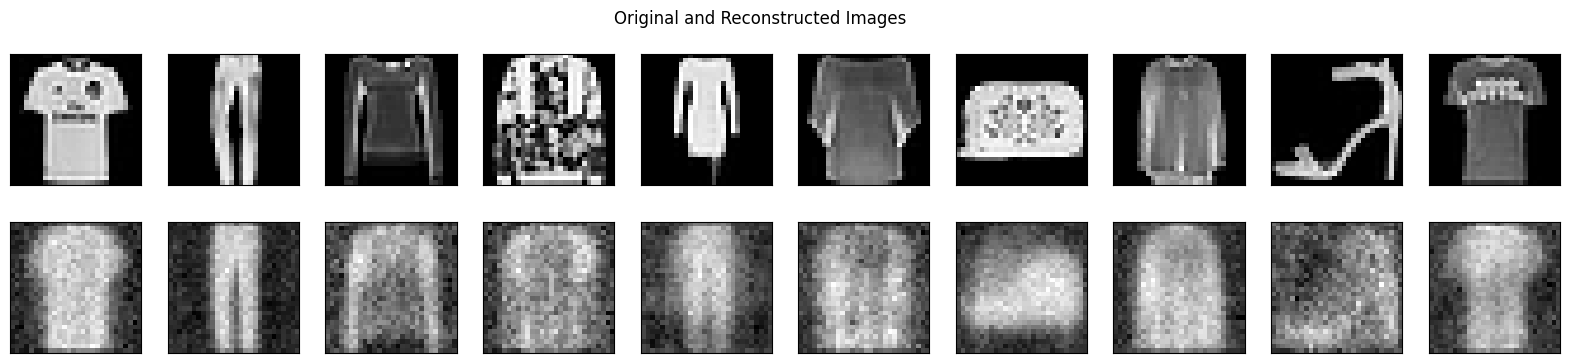

In [85]:
# visualize 10 images(original and reconstructed) from test dataset
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i][0].cpu().numpy(), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(mlp_autoencoder.predict(test_images[i][0].cpu().numpy().flatten()).reshape(28,28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Original and Reconstructed Images")
plt.show()

## 4.4 PCA AutoEncoder

### 4.4.2 Optimal number of components

In [184]:
# mse vs num_components
for num_comp in range(12, 784, 50):
    pca_autoencoder = PCA_AutoEncoder(hidden_size=num_comp)
    orig = loader_to_matrix(val_loader)
    pca_autoencoder.fit(loader_to_matrix(train_loader))
    encoded = pca_autoencoder.encode(orig)
    decoded = pca_autoencoder.decode(encoded)
    print(f"Num Components: {num_comp}, MSE: {F.mse_loss(orig, decoded)}")

Num Components: 12, MSE: 0.022879013791680336
Num Components: 62, MSE: 0.010600248351693153
Num Components: 112, MSE: 0.0070479377172887325
Num Components: 162, MSE: 0.005109797231853008
Num Components: 212, MSE: 0.0038229702040553093
Num Components: 262, MSE: 0.002895406214520335
Num Components: 312, MSE: 0.002197324763983488
Num Components: 362, MSE: 0.0016537681221961975
Num Components: 412, MSE: 0.001223245752044022
Num Components: 462, MSE: 0.0008819521754048765
Num Components: 512, MSE: 0.0006111843977123499
Num Components: 562, MSE: 0.0003986787050962448
Num Components: 612, MSE: 0.00023652511299587786
Num Components: 662, MSE: 0.00011521179840201512
Num Components: 712, MSE: 3.628264312283136e-05
Num Components: 762, MSE: 2.0197301182633964e-06


In [202]:
# elbow method to find optimal number of components
mse = []
for num_comp in range(2, 20, 1):
    pca_autoencoder = PCA_AutoEncoder(hidden_size=num_comp)
    orig = loader_to_matrix(val_loader)
    pca_autoencoder.fit(loader_to_matrix(train_loader))
    encoded = pca_autoencoder.encode(orig)
    decoded = pca_autoencoder.decode(encoded)
    mse.append(F.mse_loss(orig, decoded).item())

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(2, 20), y=mse, mode="lines"))
fig.update_layout(title="MSE vs Number of Components", xaxis_title="Number of Components", yaxis_title="MSE")
fig.update_yaxes(type="log")
fig.show()
# k_optimal = 10

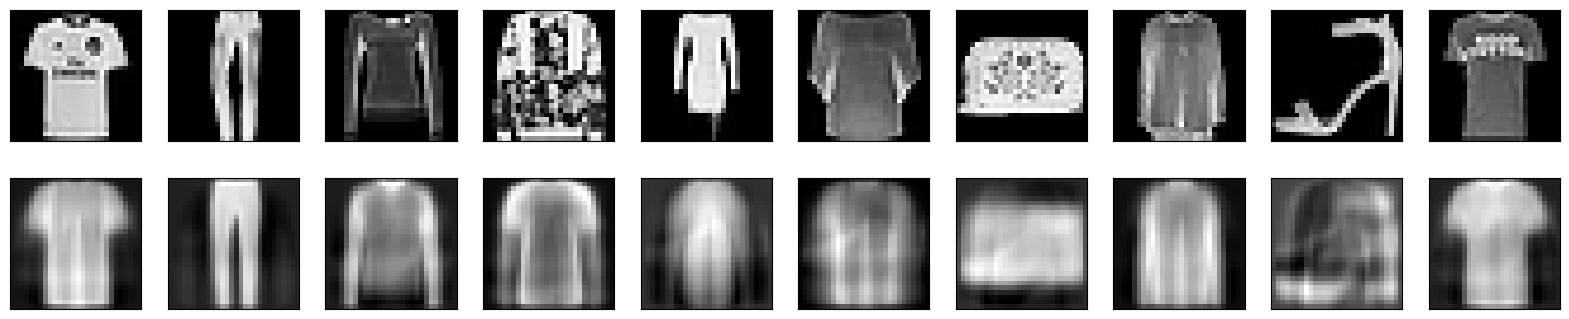

In [213]:
# visualize 10 images(original and reconstructed) from test dataset
n = 10
pca_autoencoder = PCA_AutoEncoder(hidden_size=10)
pca_autoencoder.fit(pca_autoencoder.loader_to_matrix(train_loader))
orig = test_images.reshape(-1, 784)
encoded = pca_autoencoder.encode(orig)
decoded = pca_autoencoder.decode(encoded)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(orig[i].cpu().numpy().reshape(28,28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i].cpu().numpy().reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 4.5 KNN Classification

In [187]:
k_optimal = 10

In [188]:
# get latent features from CNN autoencoder
cnn_autoencoder = CNNAutoencoder(epochs=10, kernel_sizes=[3,3,3], channel_sizes=[16,32,1], activation_functions=[nn.Sigmoid(), nn.Sigmoid(), nn.Sigmoid()])
cnn_autoencoder.fit(train_loader, val_loader)
train_cnn_latent = cnn_autoencoder.get_latent_representation(train_images).reshape(-1,9).cpu().numpy()
test_cnn_latent = cnn_autoencoder.get_latent_representation(test_images).reshape(-1,9).cpu().numpy()

Using device: cuda
Epoch: 1/10, Train Loss: 0.064251026405436
	Validation Loss: 0.0394290259974018
Epoch: 2/10, Train Loss: 0.03751957590413063
	Validation Loss: 0.03606648842810066
Epoch: 3/10, Train Loss: 0.035109781915002775
	Validation Loss: 0.035179234744541966
Epoch: 4/10, Train Loss: 0.03331490172325726
	Validation Loss: 0.03254973458921074
Epoch: 5/10, Train Loss: 0.03228783368578424
	Validation Loss: 0.03194798670329486
Epoch: 6/10, Train Loss: 0.031615428014389234
	Validation Loss: 0.03117998601619605
Epoch: 7/10, Train Loss: 0.031017850298444023
	Validation Loss: 0.030595371369153832
Epoch: 8/10, Train Loss: 0.030370809857154745
	Validation Loss: 0.030081286362022352
Epoch: 9/10, Train Loss: 0.029901741996712392
	Validation Loss: 0.030971038374741366
Epoch: 10/10, Train Loss: 0.02950432154652484
	Validation Loss: 0.02943667532152431


In [189]:
# get latent features from MLP autoencoder
mlp_autoencoder = AutoEncoder_MLP(epochs=10, learning_rate=0.001, input_dim=784, reduced_dims=9, num_neurons=[512, 128, 64], num_hidden_layers=3, activation_function="tanh",optimizer="minibatch-gd", log_local=True)
mlp_autoencoder.fit(train_in, True, val_in)
train_mlp_latent = mlp_autoencoder.get_latent(train_images.numpy().reshape(-1,784))
test_mlp_latent = mlp_autoencoder.get_latent(test_images.numpy().reshape(-1,784))

Epoch 1/10
Train Cost: 0.07086006148809139
Train MSE: 0.07086006148809139
Validation Cost: 0.07138444152819479
Validation MSE: 0.07138444152819479
Epoch 2/10
Train Cost: 0.06180572210005638
Train MSE: 0.06180572210005638
Validation Cost: 0.06230387729612394
Validation MSE: 0.06230387729612394
Epoch 3/10
Train Cost: 0.052324881979711364
Train MSE: 0.052324881979711364
Validation Cost: 0.05274244520372054
Validation MSE: 0.05274244520372054
Epoch 4/10
Train Cost: 0.04810817331927906
Train MSE: 0.04810817331927906
Validation Cost: 0.048494959078626464
Validation MSE: 0.048494959078626464
Epoch 5/10
Train Cost: 0.04530416772409381
Train MSE: 0.04530416772409381
Validation Cost: 0.04568725996468489
Validation MSE: 0.04568725996468489
Epoch 6/10
Train Cost: 0.043080018094012934
Train MSE: 0.043080018094012934
Validation Cost: 0.04345263663524296
Validation MSE: 0.04345263663524296
Epoch 7/10
Train Cost: 0.041144376106338754
Train MSE: 0.041144376106338754
Validation Cost: 0.04151229886746242

In [190]:
# get latent features from PCA autoencoder
pca_autoencoder = PCA_AutoEncoder(hidden_size=9)
pca_autoencoder.fit(loader_to_matrix(train_loader))
train_pca_latent = pca_autoencoder.encode(train_images.reshape(-1, 784)).numpy()
test_pca_latent = pca_autoencoder.encode(test_images.reshape(-1, 784)).numpy()

In [191]:
# convert to dataframes
train_cnn_latent_df = pd.DataFrame(train_cnn_latent)
test_cnn_latent_df = pd.DataFrame(test_cnn_latent)
train_mlp_latent_df = pd.DataFrame(train_mlp_latent)
test_mlp_latent_df = pd.DataFrame(test_mlp_latent)
train_pca_latent_df = pd.DataFrame(train_pca_latent)
test_pca_latent_df = pd.DataFrame(test_pca_latent)


In [192]:
train_cnn_latent.shape, test_cnn_latent.shape, train_mlp_latent.shape, test_mlp_latent.shape, train_pca_latent.shape, test_pca_latent.shape

((50000, 9), (10000, 9), (50000, 9), (10000, 9), (50000, 9), (10000, 9))

In [193]:
knn_cnn = KNN(k=28, metric='manhattan')
knn_mlp = KNN(k=28, metric='manhattan')
knn_pca = KNN(k=28, metric='manhattan')

In [194]:
knn_cnn.fit(pd.DataFrame(train_cnn_latent), pd.Series(train_labels.reshape(-1)))
knn_mlp.fit(pd.DataFrame(train_mlp_latent), pd.Series(train_labels.reshape(-1)))
knn_pca.fit(pd.DataFrame(train_pca_latent), pd.Series(train_labels.reshape(-1)))

Fitting: 100%|██████████| 1/1 [00:00<00:00, 31775.03point/s]


In [195]:
pred_cnn_train = knn_cnn.predict(pd.DataFrame(train_cnn_latent))
pred_mlp_train = knn_mlp.predict(pd.DataFrame(train_mlp_latent))
pred_pca_train = knn_pca.predict(pd.DataFrame(train_pca_latent))
pred_cnn_test = knn_cnn.predict(pd.DataFrame(test_cnn_latent))
pred_mlp_test = knn_mlp.predict(pd.DataFrame(test_mlp_latent))
pred_pca_test = knn_pca.predict(pd.DataFrame(test_pca_latent))

Predicting: 100%|██████████| 200/200 [00:04<00:00, 41.82chunk/s]


In [196]:
# get accuracy using sklearn
cnn_train_acc = accuracy_score(train_labels, pred_cnn_train) * 100
mlp_train_acc = accuracy_score(train_labels, pred_mlp_train) * 100
pca_train_acc = accuracy_score(train_labels, pred_pca_train) * 100
cnn_test_acc = accuracy_score(test_labels, pred_cnn_test) * 100
mlp_test_acc = accuracy_score(test_labels, pred_mlp_test) * 100
pca_test_acc = accuracy_score(test_labels, pred_pca_test) * 100

print(f"Train Accuracy CNN: {cnn_train_acc}%")
print(f"Train Accuracy MLP: {mlp_train_acc}%")
print(f"Train Accuracy PCA: {pca_train_acc}%")
print(f"Test Accuracy CNN: {cnn_test_acc}%")
print(f"Test Accuracy MLP: {mlp_test_acc}%")
print(f"Test Accuracy PCA: {pca_test_acc}%")

Train Accuracy CNN: 80.262%
Train Accuracy MLP: 78.464%
Train Accuracy PCA: 81.806%
Test Accuracy CNN: 78.55%
Test Accuracy MLP: 76.85%
Test Accuracy PCA: 80.60000000000001%


In [197]:
# plot accuracies of the models
fig = go.Figure()
fig.add_trace(go.Bar(x=["CNN", "MLP", "PCA"], y=[cnn_train_acc, mlp_train_acc, pca_train_acc], name="Train Accuracy"))
fig.add_trace(go.Bar(x=["CNN", "MLP", "PCA"], y=[cnn_test_acc, mlp_test_acc, pca_test_acc], name="Test Accuracy"))
fig.update_layout(title="Train and Test Accuracies of Models", xaxis_title="Model", yaxis_title="Accuracy")
fig.show()

In [198]:
# plot confusion matrix for the three models
fig = make_subplots(rows=1, cols=3, subplot_titles=["CNN", "MLP", "PCA"])
fig.add_trace(go.Heatmap(z=confusion_matrix(test_labels, pred_cnn_test), colorscale="Viridis"), row=1, col=1)
fig.add_trace(go.Heatmap(z=confusion_matrix(test_labels, pred_mlp_test), colorscale="Viridis"), row=1, col=2)
fig.add_trace(go.Heatmap(z=confusion_matrix(test_labels, pred_pca_test), colorscale="Viridis"), row=1, col=3)
fig.update_xaxes(title_text="Predicted", row=1, col=1)
fig.update_xaxes(title_text="Predicted", row=1, col=2)
fig.update_xaxes(title_text="Predicted", row=1, col=3)
fig.update_yaxes(title_text="Actual", row=1, col=1)
fig.update_yaxes(title_text="Actual", row=1, col=2)
fig.update_yaxes(title_text="Actual", row=1, col=3)
fig.update_layout(title="Confusion Matrix for Models", width=900, height=400, showlegend=False)
fig.show()